In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

In [2]:
def scale_factor_spectrum(z,data,error,wave):
    k = 1+z
    select1 = (wave>5030*k) & (wave<5050*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact

def blr_sigma(obj,z,mini_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (mini_wave>4500*k) & (mini_wave < 5200*k)
    blr_recons = double_BLR(mini_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    m_0 = np.sum(double_BLR(mini_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    m_1 = np.sum(mini_wave[select]*double_BLR(mini_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))/m_0
    m_2 = np.sqrt(np.sum(double_BLR(mini_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)*(mini_wave[select]-m_1)**2)/m_0)
    sigma_Hb_blr = c*(m_2)/m_1
    return sigma_Hb_blr

def blr_FWHM(obj,z,mini_wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2):
    c = 300000
    k = 1+z
    select = (mini_wave>4500*k) & (mini_wave<5200*k)
    (wav,dat) = (mini_wave[select],double_BLR(mini_wave[select],amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2))
    #print (wav[select])
    amp = np.max(dat)
    select = (dat>amp/2) & (dat<amp)
    fwhm = wav[select][-1] - wav[select][0]
    fwhm = (fwhm/4861.33)*(c/(1+z))
    return fwhm

def flux_FeII_5018(amp_FeII_5018_1,amp_FeII_5018_2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_FeII_5018_1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_FeII_5018_2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)
    else:
        flux = flux1 
    return flux

In [3]:
def aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2=False,MC_loops=100):
    k = 1+z
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,int_spectrum,int_err),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,int_spectrum,int_err))*(int_err)+int_spectrum 
    residual = int_spectrum - fitted
    v_out = popt_full_fit[2] - popt_full_fit[6]
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = popt_full_fit
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    wave = k*np.arange(4400,5200,0.01)
    sigma_Hb_blr = blr_sigma(obj,z,wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    FWHM_Hb_blr = blr_FWHM(obj,z,wave,amp_Hb1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,vel_Hb2,vel_sigma_Hb2)
    Hb_flux = flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    Hb_lum = Hb_blr_lum(z,Hb_flux) 
    Hb_blr_flux = flux_Hb_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    FeII_5018_flux = flux_FeII_5018(amp_Fe5018_1,amp_Fe5018_2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    sigma_eff_OIII = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
    sigma_eff_OIII_br = line_width_recons(vel_sigma_OIII_br,rest_line=5006.8,inst_res_fwhm=0)
    flux_5007_core = amp_OIII5007*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII))
    flux_5007_wing = amp_OIII5007_br*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br))
    flux_OIII = (flux_5007_core + flux_5007_wing)
    OIII_lum = lum_OIII(z,flux_OIII)
             
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    w80 = line_shape_par(z,wav_min,wav_max,cor_popt)
    parameters = [amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c,v_out,w80,Hb_lum,Hb_blr_flux,flux_5007_core,flux_5007_wing,flux_OIII,OIII_lum,sigma_Hb_blr,FWHM_Hb_blr,FeII_5018_flux]

    spec_parameters_MC = np.zeros((len(parameters),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(int_spectrum,int_err)   
        popt_MC,pcov_MC = leastsq(full_gauss,x0=p_init,args=(mini_wave,iteration_data,int_err),maxfev = 10000000)
        v_out_MC = popt_MC[2] - popt_MC[6]
        if np.abs(v_out_MC) > 2*np.abs(v_out):
            v_out_MC = np.nan
        else:
            v_out_MC = v_out_MC
        (amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC) = popt_MC
        if amp_Hb_MC < 0 or amp_Hb_MC > 2*amp_Hb:
            amp_Hb_MC = np.nan
        else:
            amp_Hb_MC = amp_Hb_MC
        #if amp_Hb_br_MC < 0 or amp_Hb_br_MC > 2*amp_Hb_br:
            #amp_Hb_br_MC = np.nan
        #else:
            #amp_Hb_br_MC = amp_Hb_br_MC
        if amp_OIII5007_MC < 0 or amp_OIII5007_MC > 2*amp_OIII5007:
            amp_OIII5007_MC = np.nan
        else:
            amp_OIII5007_MC = amp_OIII5007_MC
        if amp_OIII5007_br_MC < 0 or amp_OIII5007_br_MC > 2*amp_OIII5007_br:
            amp_OIII5007_br_MC = np.nan
        else:
            amp_OIII5007_br_MC = amp_OIII5007_br_MC
        if amp_Hb1_MC < 0 or amp_Hb1_MC > 2*amp_Hb1:
            amp_Hb1_MC = np.nan
        else:
            amp_Hb1_MC = amp_Hb1_MC
        if amp_Hb2_MC < 0 or amp_Hb2_MC > 2*amp_Hb2:
            amp_Hb2_MC = np.nan
        else:
            amp_Hb2_MC = amp_Hb2_MC
        if amp_Fe5018_1_MC < 0 or amp_Fe5018_1_MC > 2*amp_Fe5018_1:
            amp_Fe5018_1_MC = np.nan
        else:
            amp_Fe5018_1_MC = amp_Fe5018_1_MC
        if amp_Fe5018_2_MC < 0 or amp_Fe5018_2_MC > 2*amp_Fe5018_2:
            amp_Fe5018_2_MC = np.nan
        else:
            amp_Fe5018_2_MC = amp_Fe5018_2_MC
        if vel_sigma_OIII_MC < 0 or vel_sigma_OIII_MC > 2*vel_sigma_OIII:
            vel_sigma_OIII_MC = np.nan
        else:
            vel_sigma_OIII_MC = vel_sigma_OIII_MC
        if vel_sigma_OIII_br_MC < 0 or vel_sigma_OIII_br_MC > 2*vel_sigma_OIII_br:
            vel_sigma_OIII_br_MC = np.nan
        else:
            vel_sigma_OIII_br_MC = vel_sigma_OIII_br_MC
       
        sigma_eff_Hb1_MC = line_width_recons(vel_sigma_Hb1_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_Hb2_MC = line_width_recons(vel_sigma_Hb2_MC,rest_line=4861.33,inst_res_fwhm=0) 
        wave = k*np.arange(4400,5200,0.01)
        try:
            sigma_Hb_blr_MC = blr_sigma(obj,z,wave,amp_Hb1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC)
        except IndexError:
            sigma_Hb_blr_MC = np.nan
        try:
            FWHM_Hb_blr_MC = blr_FWHM(obj,z,wave,amp_Hb1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC)
        except IndexError:
            FWHM_Hb_blr_MC = np.nan
        Hb_flux_MC = flux_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        FeII_5018_flux_MC = flux_FeII_5018(amp_Fe5018_1_MC,amp_Fe5018_2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        Hb_lum_MC = Hb_blr_lum(z,Hb_flux_MC)  
        Hb_blr_flux_MC = flux_Hb_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        if Hb_blr_flux_MC < 0 or Hb_blr_flux_MC > 2*Hb_blr_flux or Hb_blr_flux_MC == np.nan:
            Hb_blr_flux_MC = np.nan
        else:
            Hb_blr_flux_MC = Hb_blr_flux_MC
        sigma_eff_OIII_MC = line_width_recons(vel_sigma_OIII_MC,rest_line=5006.8,inst_res_fwhm=0)
        sigma_eff_OIII_br_MC = line_width_recons(vel_sigma_OIII_br_MC,rest_line=5006.8,inst_res_fwhm=0)
        flux_5007_core_MC = amp_OIII5007_MC*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_MC))
        if flux_5007_core_MC < 0 or flux_5007_core_MC > 2*flux_5007_core:
            flux_5007_core_MC = np.nan
        else:
            flux_5007_core_MC = flux_5007_core_MC
       
        flux_5007_wing_MC = amp_OIII5007_br_MC*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_OIII_br_MC))
        if flux_5007_wing_MC < 0 or flux_5007_wing_MC > 2*flux_5007_wing:
            flux_5007_wing_MC = np.nan
        else:
            flux_5007_wing_MC = flux_5007_wing_MC

        flux_OIII_MC = (flux_5007_core_MC + flux_5007_wing_MC)
        OIII_lum_MC = lum_OIII(z,flux_OIII_MC) 
        cor_popt_MC = np.array([amp_OIII5007_MC,amp_OIII5007_br_MC,vel_OIII_MC,vel_sigma_OIII_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC])
        (wav_min,wav_max) = wavlim(vel_OIII_MC,vel_OIII_br_MC)
        try:
            w80_MC = line_shape_par(z,wav_min,wav_max,cor_popt_MC)
            if w80_MC < 0 or w80_MC > 2*w80:
                w80_MC = np.nan
            else:
                w80_MC = w80_MC
        except IndexError:
            w80_MC = np.nan
        par_MC = [amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC,v_out_MC,w80_MC,Hb_lum_MC,Hb_blr_flux_MC,flux_5007_core_MC,flux_5007_wing_MC,flux_OIII_MC,OIII_lum_MC,sigma_Hb_blr_MC,FWHM_Hb_blr_MC,FeII_5018_flux_MC]
        spec_parameters_MC[:,l]=par_MC
    spec_parameters_err = np.nanstd(spec_parameters_MC,1)
    return parameters,spec_parameters_err,fitted,residual



In [4]:
def flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def flux_Hb_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)
    else:
        flux = flux1
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum

def flux_FeII_5018(amp_FeII_5018_1,amp_FeII_5018_2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_FeII_5018_1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_FeII_5018_2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)
    else:
        flux = flux1
    return flux
    
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
   # print (cumsum)
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
 
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80

def lum_OIII(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    OIII_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux) - 16
    return OIII_lum


In [5]:
def central_table(obj,output_par,output_par_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'w80':19,'log_L_Hb':20,
              'Hb_flux':21,'OIII_core_flux':22,'OIII_wing_flux':23, 'OIII_total_flux':24, 'log_L_OIII':25,
              'vel_sigma_Hb':26,'FWHM_Hb':27,'FeII_5018_flux':28}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def central_table_with_source(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_nonfixkin_aperture.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit,w80_fit,Hb_lum_fit,Hb_blr_flux_fit,flux_5007_core_fit,flux_5007_wing_fit,flux_OIII_fit,OIII_lum_fit,Hb_blr_sigma_fit,Hb_blr_FWHM_fit,FeII_5018_flux_fit) = popt
    output_par = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit] 
    k = 1+z
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(output_par,mini_wave,int_spectrum,int_err)*(int_err)+int_spectrum
    residual = int_spectrum - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(mini_wave,int_spectrum,'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(mini_wave,fit,'r:',label='fit')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(mini_wave,Hb_O3_gauss(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    #plt.plot(wo_wave[select],residual,label='residual')
    #plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    #plt.title('All Components'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/Aperture Spectrum/Fit/%s_central_spectrum_components.png'%(destination_path_cube,obj),overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(mini_wave,residual/int_err,drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/Aperture Spectrum/Residuals/%s_central_spectrum_components.png'%(destination_path_cube,obj),overwrite=True)

    #fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    

In [6]:
def spectroastrometric_script(obj,p_init,z,broad2,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    k = 1+z
    print ('%s'%(obj))
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube.fits'%(destination_path_cube,obj,obj))
    (int_spectrum,int_err) = int_spec(mini_cube,mini_err)
    factor = scale_factor_spectrum(z,int_spectrum,int_err,mini_wave)
    print (factor)
    int_err = factor*int_err
    (popt,popt_err,fitted,residual) = aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2,MC_loops=100)
    print (popt,popt_err)
    plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2)
    
    central_table(obj,popt,popt_err)
    central_table_with_source(obj)

HE0114-0015
2.6425297


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


[9.490022328570733, 9.396293226543511, 13674.43088510871, 124.77374970978985, -0.13126780829043222, 0.6278251845412046, 13667.11017352472, 390.6330507521561, 1.783325218688977, 0.5353495335660493, 13699.168623352874, 1196.4936435093055, 0.0, 0.0, 13680.0, 1000.0, -0.23908224302845865, 2.5907579099053955, 7.320711583990487, 377.0694350028047, 40.628575465822095, 87.01623626438659, 49.06698546649441, 10.273123500801674, 59.34010896729608, 40.462323510594146, 1148.8249209974272, 2704.815348945033, 26.12204493528057] [2.11496340e-01 1.91822243e-01 1.14358693e+01 4.82945139e+00
 1.67127081e+00 1.49921763e-01 7.13277007e+01 5.96085900e+01
 1.35281391e-01 3.23784263e-02 4.56674603e+01 4.98154241e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.45467109e-02 4.33379584e-01 6.75589461e+00 1.44154095e+01
 2.90948265e-02 4.74502892e+00 1.42404930e+00 1.96274433e+00
 1.28530956e+00 9.39559927e-03 4.80756059e+01 1.13074318e+02
 1.75035520e+00]


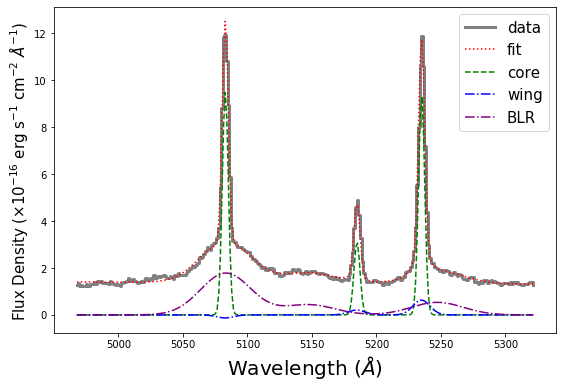

No handles with labels found to put in legend.


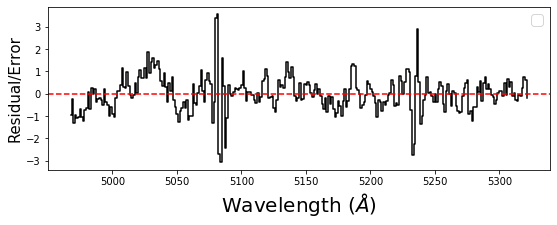

In [7]:
z = {"HE0114-0015":0.04560}

objs = z.keys()

broad2= {'HE0114-0015':False}
#'HE0021-1810':False,
p_init= {'HE0114-0015':[9.490047836951893, 9.396340379926198, 13674.431001669504, 124.7744582916058, -0.13132445168544238, 0.627771973320316, 13667.099597105385, 390.65131348620724, 1.7833461588553483, 0.5353495626551986, 13699.168330455297, 1196.4876459558461, 0.0, 0.0, 13680.0, 1000.0, -0.23908160643000811, 2.5907550089653895]}
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   

HE0021-1810
2.0670912
[1.2078086761644493, 17.21625736797099, 16109.438661627197, 109.45433451215077, 0.32003648563176884, 10.221691728073594, 16011.0432880548, 299.044332755819, 1.2124877368735225, 1.89632742911659, 10860.551631477902, 2396.7312263741724, 0.0, 0.0, 15959.0, 1000.0, 1.1613706946794835, 1.7761393244731154, 98.39537357239715, 577.8457646728195, 40.90854001201278, 118.98823686880799, 78.86042521386689, 128.00307579741488, 206.86350101128176, 41.14871985320521, 2331.6240875297767, 5399.7568567805265, 186.09726965022458] [2.98364296e-01 9.47722789e-01 4.71077605e+00 7.36808397e+00
 2.11645757e-01 1.02015231e+00 8.70138424e+00 1.37029457e+01
 1.77966246e-01 1.21295762e-01 1.10192381e+02 5.63776407e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.17062890e-01 3.80769564e+00 9.24259936e+00 1.26380340e+01
 6.37777137e-02 1.71099590e+01 8.93929662e+00 7.71226133e+00
 2.88930100e+00 6.05570777e-03 5.51821470e+01 1.28111472e+02
 1.15035366e+01]


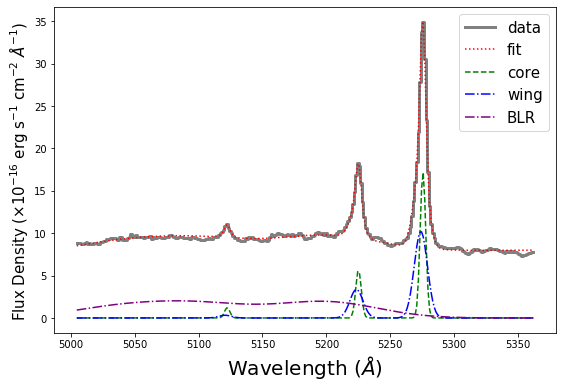

No handles with labels found to put in legend.


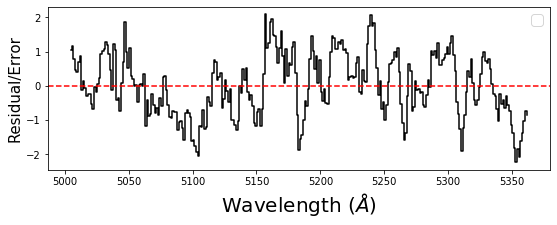

HE0021-1819
1.3953673
[4.2866259879270725, 44.036068652458454, 15957.984876572746, 73.23578840275131, 1.2781180512867205, 8.725041754043897, 15825.40415140385, 297.4114384799879, 1.3254524543262007, 0.15578738394975827, 16007.103599748842, 1552.8067082035684, 0.0, 0.0, 15959.0, 1000.0, -0.9002893082846563, 6.223351623690795, 132.5807251688948, 467.6524515304667, 40.7520360423089, 84.03478447070177, 134.94812568729742, 108.66379421481695, 243.61191990211438, 41.21427548622036, 1481.8203806346044, 3489.168602084206, 9.877049297952787] [4.93845380e-02 1.06005135e-01 1.90589244e-01 3.73025209e-01
 3.35537005e-02 7.03249992e-02 1.28892263e+00 1.14893115e+00
 1.26847573e-02 9.81149205e-03 1.41683714e+01 1.41486418e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.63236391e-02 1.36753953e-01 1.32573504e+00 1.36593003e+00
 3.97266568e-03 7.70580716e-01 6.97599868e-01 6.39048117e-01
 4.14781816e-01 7.39205322e-04 1.35510158e+01 3.19771356e+01
 6.07384165e-01]


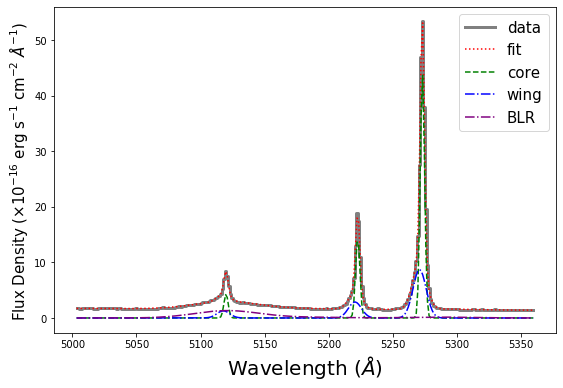

No handles with labels found to put in legend.


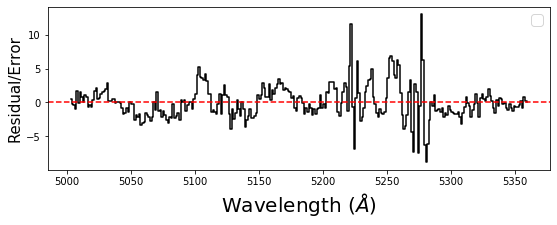

HE0040-1105
3.0069668
[7.823484240805574, 85.94287105044809, 12568.038841290925, -67.05426708790716, 2.701622079801911, 17.297979254724023, 12470.687142927636, 251.82850460617928, 7.471311305103894, 0.816269258670657, 12920.017115037148, 1172.3422700848114, 0.0, 0.0, 12507.0, 1000.0, 0.8141456076084845, 0.24705125514672707, 97.35169836328896, 387.68730389710817, 41.16155881419057, 357.170435416188, 241.02835719187166, 182.3870058136805, 423.4153630055522, 41.23544992267783, 1128.3473092805543, 2660.3830639521234, 39.02223246099815] [1.95149519e-01 4.26233691e-01 3.96599226e-01 4.36872027e+01
 1.48813370e-01 3.73141254e-01 2.86152835e+00 2.62173463e+00
 5.39806326e-02 3.18162616e-02 6.41042798e+00 7.33950238e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.76977465e-02 4.47638236e-01 2.93510867e+00 2.41815532e+00
 2.84650865e-03 2.33741111e+00 3.32325344e+00 2.46769484e+00
 1.56671659e+00 1.60574255e-03 7.08980233e+00 1.67642747e+01
 1.52933500e+00]


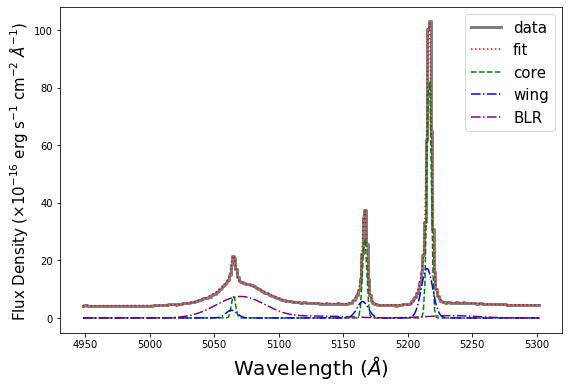

No handles with labels found to put in legend.


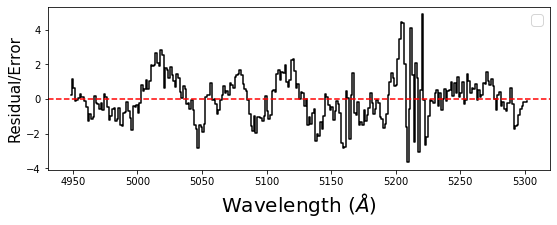

HE0108-4743
2.0220816
[39.237509576585836, 85.34035825919393, 7162.202809714782, 41.69349856179321, 4.144577073049878, 59.555724957356055, 7103.854981971741, 112.40899238807597, 5.925038602353794, 1.8055269125570788, 7035.406617562747, 1281.3326697227762, 20.665960131901663, 3.7106563119605176, 7181.556306951209, 430.87102976458374, 2.302209627160883, -0.04950347870270808, 58.34782774304131, 235.24534487349965, 40.94200307220379, 671.8981306829278, 148.87167863060301, 280.16653094643976, 429.0382095770428, 40.747195610982814, 910.5743889709929, 1162.6447906485405, 159.40799880256833] [1.47689407e+00 6.19286919e+00 2.24440107e+00 4.09718637e+00
 1.86190389e+00 6.16854198e+00 4.66860199e+00 4.18433123e+00
 8.05129623e-01 2.63696007e-01 5.80839624e+01 9.55152371e+01
 5.62877403e-01 2.79803842e-01 6.49127503e+00 2.05362329e+01
 2.69385413e-01 1.36847597e+00 3.96010472e+00 3.65057533e+00
 5.46658586e-03 8.45032071e+00 2.44467633e+01 2.03160122e+01
 5.52004963e+00 5.59130992e-03 4.48072566e+

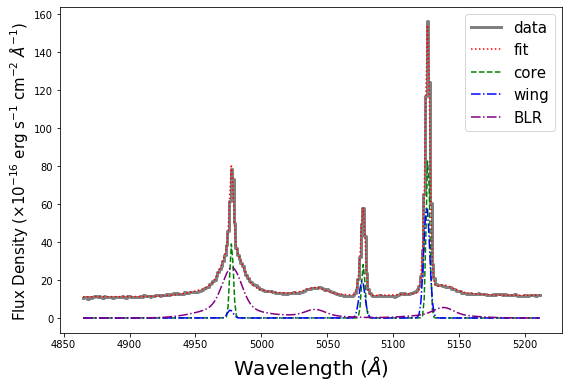

No handles with labels found to put in legend.


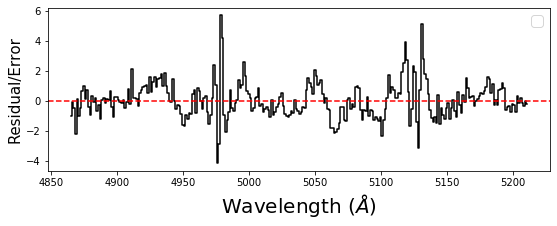

HE0114-0015
2.6425297
[9.490047836951893, 9.396340379926198, 13674.431001669504, 124.7744582916058, -0.13132445168544238, 0.627771973320316, 13667.099597105385, 390.65131348620724, 1.7833461588553483, 0.5353495626551986, 13699.168330455297, 1196.4876459558461, 0.0, 0.0, 13680.0, 1000.0, -0.23908160643000811, 2.5907550089653895, 7.331404564118202, 377.0694350028047, 40.628578379695526, 87.01682009669392, 49.06751046464576, 10.272733674694798, 59.340244139340555, 40.46232449988128, 1148.8191404022414, 2704.815348945033, 26.12191489077571] [1.95494628e+01 5.93030171e+00 1.11519318e+01 1.47637522e+01
 1.95406543e+01 5.95662235e+00 5.91454792e+01 8.60752850e+01
 1.27760495e-01 3.88292010e-02 3.34118912e+01 5.70976076e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.02523842e-01 5.26199483e-01 6.11028634e+01 1.77953143e+01
 1.83992307e-02 3.60829909e+00 3.51939488e+01 3.53264419e+01
 1.88703238e+00 1.45670888e-02 5.50629722e+01 1.29652614e+02
 2.15009108e+00]


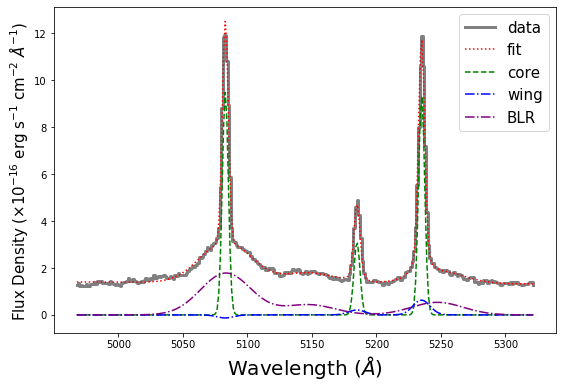

No handles with labels found to put in legend.


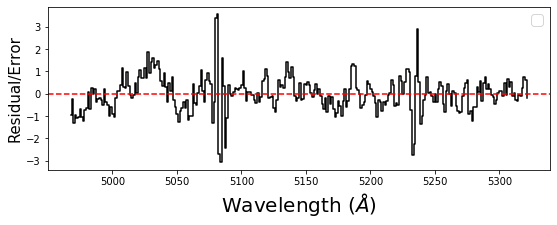

HE0119-0118
1.5138327
[18.056529303273372, 84.40959278480953, 16343.021176869965, 107.93512441729729, 1.2205180572815129, 65.33993313239984, 16133.36145594141, 241.44563987095543, 10.064871263674569, 0.11915180361294242, 16511.3781386145, 896.3722782479948, 10.63472738847762, 3.3663883315467626, 16351.326665257116, 2390.0922802735245, -12.27642943070898, 79.98170151354543, 209.65972092855372, 544.434233059977, 41.995460162590405, 1408.284482127299, 381.2762949976713, 660.5058142381729, 1041.7821092358442, 41.864546663687086, 2012.6580540111272, 3113.3455248523373, 333.7913889176086] [3.53189595e-01 1.28977020e+00 1.63339531e+00 2.01886430e+00
 4.62924147e-01 1.27728255e+00 3.71813274e+00 1.73177219e+00
 2.59944426e-01 1.45114119e-01 2.50036533e+01 4.24724809e+01
 4.24749806e-01 1.29266059e-01 3.63410990e+01 4.77556313e+01
 2.98284930e-01 1.56402707e+00 2.80732099e+00 2.35897074e+00
 2.96696471e-03 9.61891213e+00 1.24398329e+01 1.17381435e+01
 3.61786068e+00 1.50707652e-03 2.75688420e+0

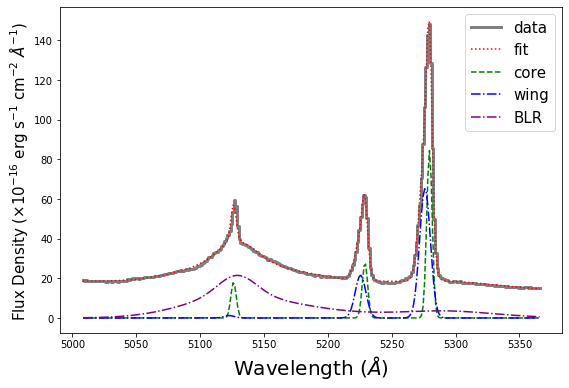

No handles with labels found to put in legend.


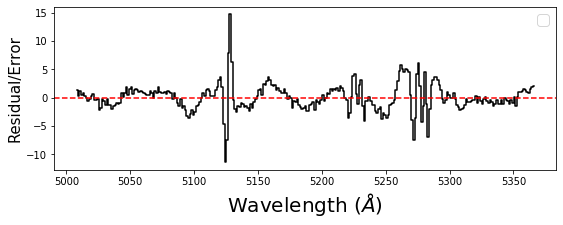

HE0212-0059
1.1814882
[4.785789594383388, 55.77838493431364, 7920.609856818633, 171.99730537262573, 0.4819336702533869, 5.605042176336324, 7641.0414879688105, 439.79844784780533, 7.173622883458875, 2.3436057619809065, 6909.937609183833, 3898.3650995548746, 1.9014254222728482, 0.8937334002662368, 4628.322206705408, 891.2090937762121, 1.3729427420278724, 0.5472734069270192, 279.56836884982204, 575.6090714012122, 41.28781587288153, 1219.9032542269185, 401.5739792643814, 103.27581735699006, 504.84979662137147, 40.90465266868434, 3792.469643240886, 8326.73363069028, 408.4348355691712] [1.35469721e-01 3.14771539e-01 1.03016329e+00 1.11218796e+00
 2.52177010e-01 3.10523787e-01 1.99549341e+01 1.59525845e+01
 7.34867464e-01 2.61220793e-01 8.43324871e+02 5.71384605e+02
 1.40141152e+00 5.79856999e-01 6.98484284e+01 2.76068013e+02
 2.20440202e+00 1.15524264e+01 1.99800923e+01 6.93906402e+00
 5.16293045e-02 1.28205319e+02 4.19764909e+00 5.25122834e+00
 3.56580726e+00 3.05606947e-03 3.03334269e+02 1

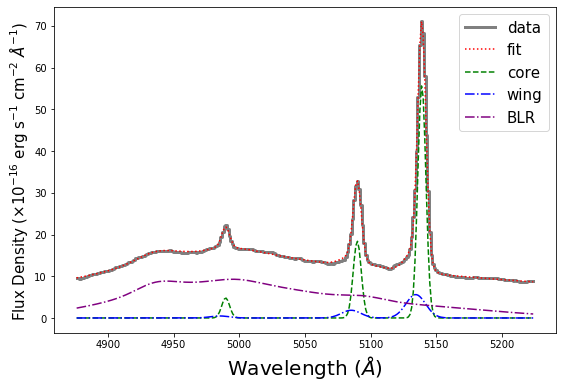

No handles with labels found to put in legend.


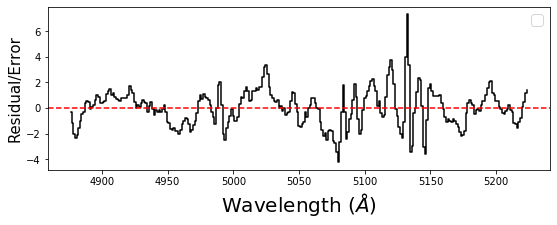

HE0224-2834
3.1328857


/home/rickeythecat/Downloads/func.py:191: RuntimeWarning: divide by zero encountered in true_divide
  line = (amplitude)*exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width_recons(vel_sigma, rest_wave))**2))


[5.062113728626249, 57.62821587010285, 17987.947395559306, 112.3869334383236, 1.7566971940387333, 16.228916196517716, 17960.877982956084, 274.4444468242226, 6.862145124626172, 1.1306095265646368, 17980.898024606347, 2169.0976164310873, 0.0, 0.0, 0.0, 0.0, -1.8684118488997554, 17.140484824517632, 27.06941260322128, 418.37797708693415, 41.71791185553238, 608.9957693286595, 271.0457774488751, 186.4963640173449, 457.54214146622, 41.59372868042512, 2061.3456336410327, 4853.610020409035, 100.33836445247896] [2.78629081e-01 9.98113975e-01 7.18746959e-01 1.78111442e+00
 2.08881878e-01 1.03812424e+00 2.96358888e+00 6.95330451e+00
 4.79868124e-02 5.24933776e-02 1.65547962e+01 1.55884793e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.32885587e-01 6.88895646e-01 3.28818004e+00 2.14079620e+00
 3.61487079e-03 5.07467202e+00 8.63214510e+00 7.54665300e+00
 1.77508869e+00 1.68386930e-03 1.49290974e+01 3.51424633e+01
 4.69592701e+00]


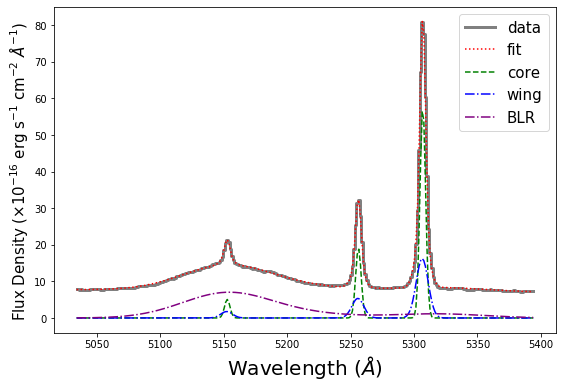

No handles with labels found to put in legend.


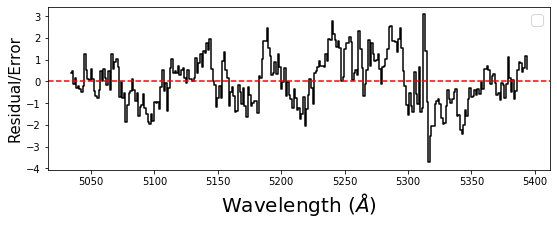

HE0227-0913
10.513516
[50.39478120849463, 82.38604817739939, 4793.5533312894895, 139.88152195490227, 28.334729519372832, 8.270655078016343, 4343.356756862294, 308.9263443513405, 43.58125901179644, 6.769064607351718, 4712.5801325851, 1342.2105677504949, 97.2360512420328, 23.388145963260577, 4919.905252376205, 381.6979779940922, -8.858191547049168, 87.88744601213871, 450.1965744271956, 571.8028267155814, 41.37531532763455, 3896.1337062936263, 482.33134923401815, 106.99690726923136, 589.3282565032495, 40.55503873988865, 1069.3321423692391, 1141.045763221428, 733.7698853878011] [4.45267917e+00 2.46396720e+00 6.02733529e+00 8.28423527e+00
 6.06347970e+00 3.09498737e+00 6.13644607e+01 4.08014482e+01
 3.05001335e+00 9.31323232e-01 1.84000179e+01 5.45021924e+01
 3.85302681e+00 8.89788399e-01 2.05222747e+01 1.94221237e+01
 1.12946282e+00 5.68163189e+00 5.65609445e+01 3.97723212e+01
 1.04368762e-02 9.69986909e+01 3.62471845e+01 2.56376398e+01
 2.05524719e+01 1.59254918e-02 3.41665244e+01 4.18577

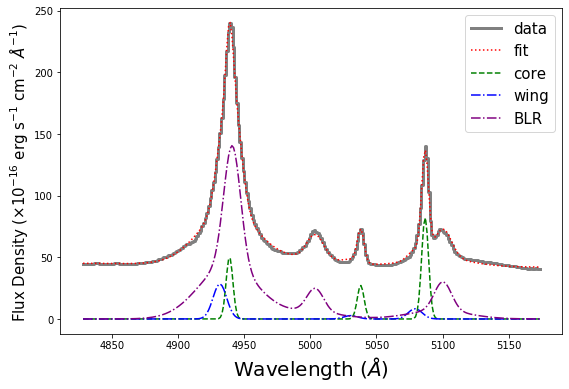

No handles with labels found to put in legend.


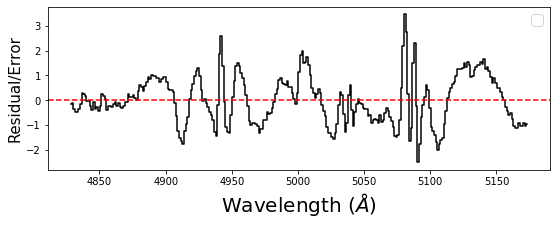

HE0232-0900
2.089414
[62.60489604006362, 659.5789776310304, 12876.602035549353, 145.11318585238368, -0.26103595029359544, 162.8860769343344, 12840.898114600517, 326.7431333263477, 97.58582274540396, 14.255226549919376, 12915.830954836818, 2205.2275567096126, 0.0, 0.0, 12942.0, 1000.0, -53.429832825117614, 375.841902877515, 35.70392094883573, 498.5823362422624, 42.58408448158779, 8805.785582902034, 4006.0164535949543, 2228.910463122465, 6234.926916717419, 42.43414774244045, 2129.861264027042, 5014.677053508463, 1286.3391925462288] [2.77872939e+00 8.56407527e+00 6.80104497e-01 1.27039031e+00
 2.25887399e+00 8.53891431e+00 2.69505565e+00 6.80627852e+00
 5.19124220e-01 4.65251944e-01 1.06987277e+01 9.93608837e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.29294218e+00 6.65731579e+00 2.93364137e+00 2.14787016e+00
 2.36687016e-03 4.80069471e+01 8.31056910e+01 7.42232047e+01
 1.94021213e+01 1.35062501e-03 9.67832577e+00 2.27457556e+01
 4.25381869e+01]


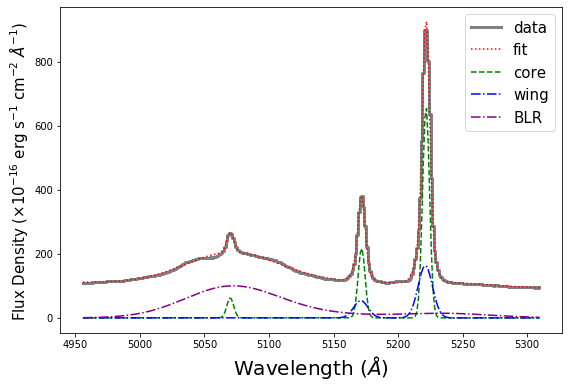

No handles with labels found to put in legend.


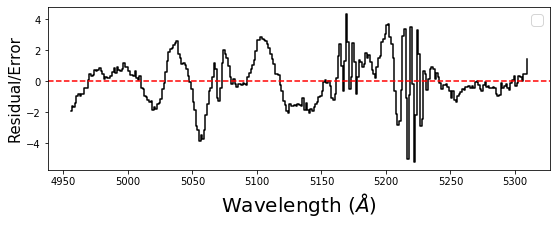

HE0253-1641
8.335442
[19.377139997211064, 192.7219498648734, 9545.035994880933, -106.35049949827129, 9.719468398583166, 65.05873196321853, 9296.79678462443, 364.0634924491613, 25.906690271294647, 6.894847711592713, 9726.761997543386, 564.1016885681445, 14.992421302305074, 3.5103209376541598, 9170.577690706838, 1730.063744690662, -1.426574185899985, 47.22428314868908, 248.2392102565027, 709.7835592318589, 41.579813160834064, 1654.3842788141296, 857.128048633737, 992.0624329600605, 1849.1904815937974, 41.62815841570056, 1413.7537130891365, 1751.9896818742782, 406.38910648793524] [1.72831536e+00 3.24288654e+00 2.32294153e+00 4.17717554e+00
 2.57134533e+00 2.99696466e+00 1.60917236e+01 1.28785501e+01
 1.77476449e+00 1.02260869e+00 4.61846212e+01 4.19287702e+01
 1.24141803e+00 1.30351962e+00 1.85366910e+02 1.28486062e+02
 1.30175651e+00 6.63435931e+00 1.47429980e+01 2.14740181e+01
 1.95151970e-02 7.19593342e+01 4.13079392e+01 2.85695898e+01
 3.74216027e+01 8.86564515e-03 8.73049718e+01 7.90

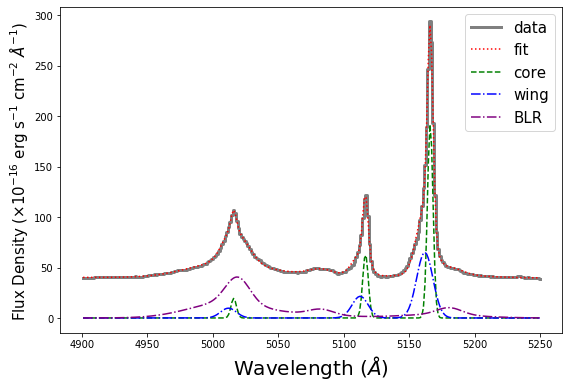

No handles with labels found to put in legend.


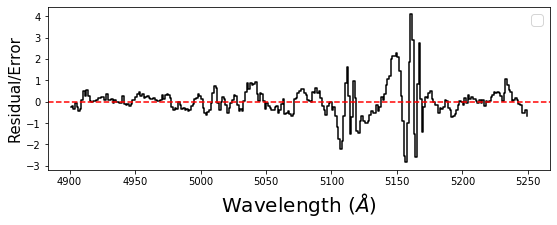

HE0345+0056
8.953899
[14.638841504573739, 174.72300941973916, 9194.390148363229, 154.84855542912516, 42.96153566267656, 113.55110706881163, 8855.826915968788, 388.094744147433, 85.28365918054321, 17.491341565783987, 9328.164472674762, 1534.668217287447, 258.58437238612777, 24.615684464847273, 9343.187064202333, 325.2416462848582, -5.620921531129615, 110.83277006165143, 338.563232394441, 878.7273362734946, 42.28715001916034, 8763.38998770812, 1132.4274984916083, 1845.95132618501, 2978.378824676618, 41.81845781562348, 1184.7529197669478, 914.5645327712406, 1421.4914436682882] [2.07312900e+01 8.25182278e+00 8.37854041e+00 1.08298369e+01
 8.40826247e+00 7.43799004e+00 2.55091019e+01 1.09665029e+01
 3.65605924e+00 1.66406140e+00 3.15652777e+01 5.18013798e+01
 1.59657636e+01 2.14423604e+00 1.55740781e+01 1.38627844e+01
 3.03991558e+00 1.55074054e+01 2.18284759e+01 1.79335569e+01
 1.07652309e-02 2.16846570e+02 1.20228302e+02 1.13120163e+02
 5.19344236e+01 7.61387728e-03 4.16522629e+01 4.06554

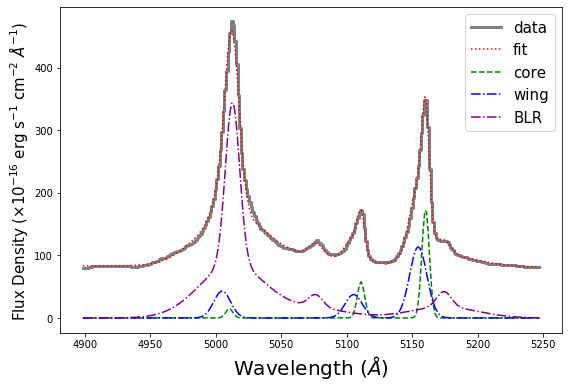

No handles with labels found to put in legend.


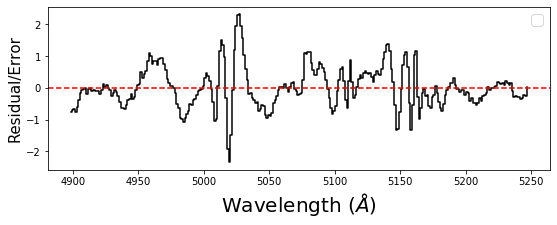

HE0351+0240
6.1162186
[18.85307435653056, 287.3701258744777, 10638.538083669862, 70.08446957514263, 7.662240484151896, 17.138525117892982, 10617.18428164049, 238.59158341383485, 10.807396309038147, 0.6027743424495905, 11578.256268801118, 316.0497007022247, 26.062471550596406, 2.6529507529395153, 10656.512719312006, 1304.9055519988299, -3.6066659199910966, 31.839868173622804, 21.353802029372673, 215.15140953175492, 41.66120850075553, 1526.317590178639, 842.7403758166503, 171.1997088767395, 1013.9400846933897, 41.48357588405598, 1236.6526747482862, 2698.0270831822363, 148.97568589946607] [1.42305775e+00 3.80641867e+00 7.68118804e-01 1.57372759e+00
 1.19688510e+00 3.64632387e+00 9.49342680e+00 2.42512490e+01
 8.49841410e-01 2.76695975e-01 1.89306477e+01 2.23687517e+01
 7.43471910e-01 2.35633793e-01 2.25970203e+01 2.45564214e+01
 5.09603659e-01 2.60235169e+00 9.91752283e+00 2.25710211e+00
 4.67230594e-03 1.64376901e+01 2.71430336e+01 2.04934605e+01
 9.99981954e+00 4.27772425e-03 2.11982814

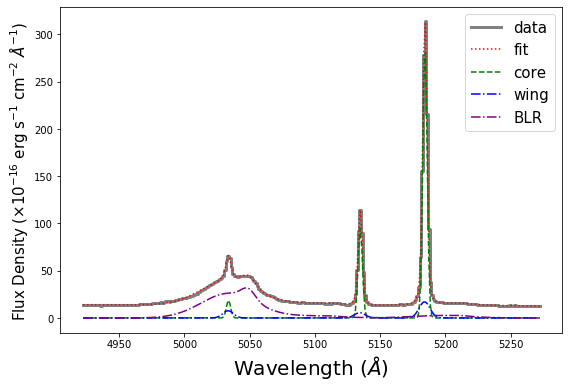

No handles with labels found to put in legend.


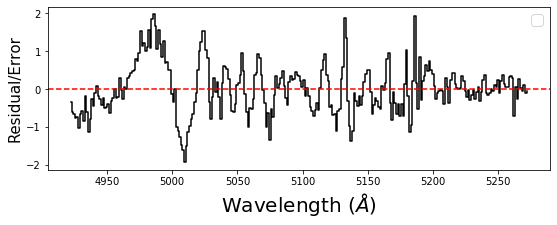

HE0412-0803
5.898816
[88.29252542913233, 1218.6256409897353, 11476.237585766568, 80.33372623080979, 20.466708371984463, 176.95874072953478, 11454.520586856213, 251.97631521161472, 39.048017525837224, 6.269710522294508, 11277.069887739312, 1793.3649289001442, 0.0, 0.0, 11448.0, 1000.0, -7.109696242448946, 60.71529017109893, 21.71699891035496, 304.74082719847763, 41.986147685881036, 2861.5108507784867, 4096.504698602468, 1866.9194882524048, 5963.4241868548725, 42.30504799122902, 1738.7884628618835, 4091.4729097662885, 459.45596799926454] [1.91427065e+00 6.45228978e+00 3.42233547e-01 8.31540877e-01
 1.29995802e+00 5.63054061e+00 1.21414501e+00 3.26313961e+00
 2.70052759e-01 1.77650461e-01 1.00050398e+01 1.23564393e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.75617073e-01 2.43781053e+00 1.32764145e+00 1.18822228e+00
 2.37930733e-03 1.56804697e+01 5.09086134e+01 3.66606542e+01
 1.97713764e+01 1.44004543e-03 1.20621068e+01 2.83737906e+01
 1.29876859e+01]


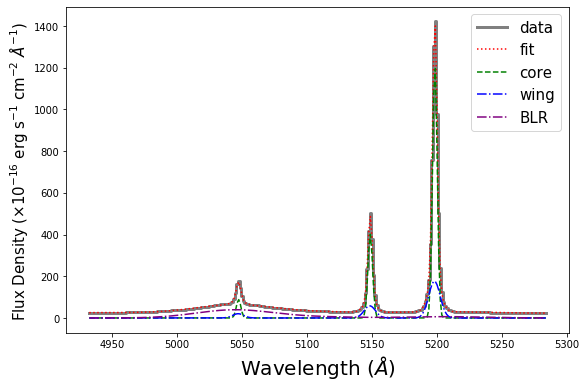

No handles with labels found to put in legend.


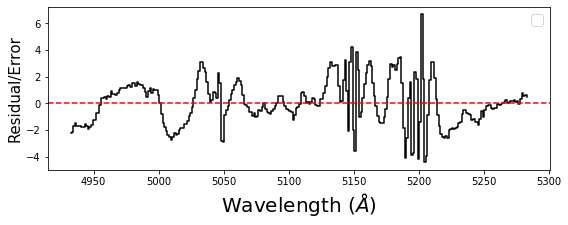

HE0429-0247
2.491752
[15.818246009969599, 100.58296836166636, 12639.258445885369, 87.57101331349142, -4.333127296146505, 21.3688250539969, 12584.351134088003, 220.08055136350288, 19.049967573007926, 0.7028382495324496, 12652.629124551979, 427.6103414248357, 14.080476482546961, 1.7648927235463496, 12676.352003615251, 1605.485113257673, -7.045630701211602, 50.276768355144455, 54.907311797365765, 320.8660293839565, 41.71393764596644, 1254.5108459423984, 368.5874440254171, 196.88378419146045, 565.4712282168775, 41.36787373803696, 1345.2495965434136, 1456.3915636573765, 127.93704876514536] [5.26555189e-01 9.40649095e-01 4.69360483e-01 1.12048382e+00
 1.25152919e+00 1.02720955e+00 3.12984189e+00 3.43613757e+00
 7.69073604e-01 7.69646991e-02 4.00482105e+00 1.36527746e+01
 2.28223131e-01 6.30755025e-02 6.47333641e+00 1.57542299e+01
 1.46373290e-01 7.47182439e-01 3.12509789e+00 1.78255195e+00
 3.33218103e-03 9.61989027e+00 7.66470962e+00 6.89881467e+00
 1.73345763e+00 1.33120935e-03 1.27578715e

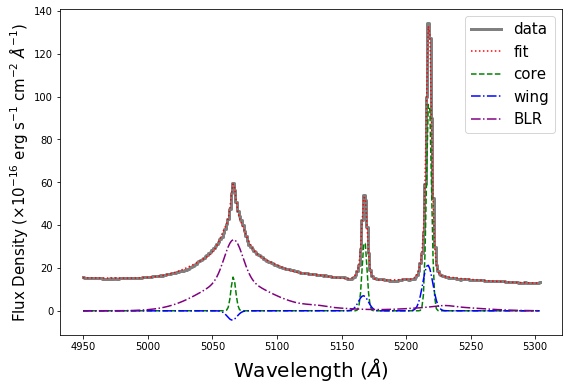

No handles with labels found to put in legend.


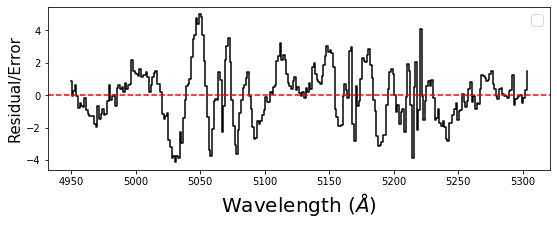

HE0433-1028
7.897525
[13.49830938562104, 82.0036725471136, 10588.86838389034, 128.1088615692355, 8.456291356597315, 88.97986596282807, 10276.462509525942, 335.304363315917, 41.23751419886434, 4.233959926186307, 10497.132697482211, 921.6571477135066, 21.289514951855853, 5.68043460740921, 11223.443685093609, 2035.0957227689887, -16.914746945281674, 117.31100949382761, 312.4058743643982, 795.0174677777848, 41.98754116843723, 3320.402880361469, 439.67006117424773, 1249.52672532634, 1689.1967865005877, 41.694030633068714, 1606.1383679596136, 2639.4011515943444, 631.7584455860631] [1.73926682e+00 2.64768329e+00 5.51710388e+00 6.89201328e+00
 1.79356979e+00 2.63351957e+00 8.73012348e+00 4.22110755e+00
 1.46747930e+00 4.98803205e-01 1.88585153e+01 4.15844048e+01
 1.78875977e+00 5.30601670e-01 7.54569409e+01 5.91315119e+01
 9.91904956e-01 4.98800147e+00 7.31125335e+00 6.72692523e+00
 4.67751796e-03 3.57623435e+01 3.42338231e+01 3.41238848e+01
 1.21405639e+01 3.12491298e-03 2.84459402e+01 6.9814

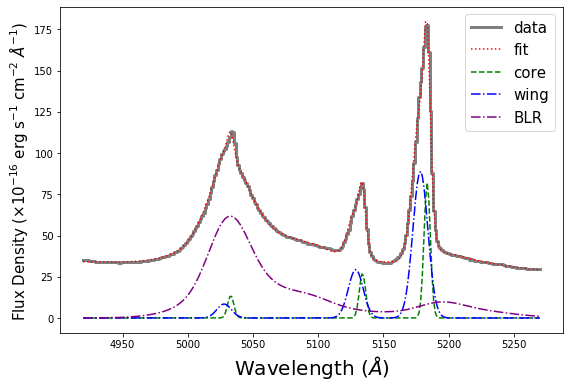

No handles with labels found to put in legend.


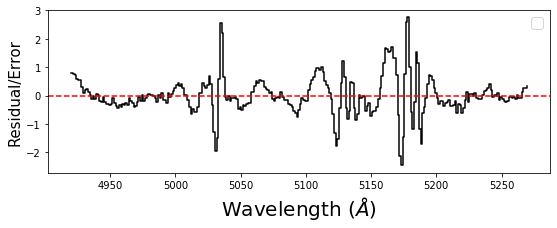

HE0853+0102
2.1295152


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


[2.4272957928539283, 14.410907798261096, 15712.721925082305, 102.26862957047784, 0.3491755212629988, 4.350807989684256, 15681.591235415428, 298.1494148327155, 1.5796162101608395, 0.12482695742251411, 17060.944420565917, 1119.5668785555401, 1.6164228879160076, 0.3119791227265866, 15126.491817725717, 1412.239201060762, -0.031330347479505034, 1.3098274934355478, 31.130689666877515, 470.46283215550983, 41.025240926284376, 165.26377037789973, 61.67522934476116, 54.32060919374567, 115.99583853850683, 40.87150567840166, 1532.7865748505596, 3918.6806903493334, 23.678493729128874] [1.00056582e-01 2.13661401e-01 8.12656646e-01 1.94539497e+00
 1.13914480e-01 2.27285651e-01 3.53967832e+00 9.21346934e+00
 3.72611712e-01 1.11596028e-01 9.76785815e+02 3.78465305e+02
 3.56333637e-01 1.17638552e-01 1.16386391e+03 1.87748048e+02
 1.49478950e-01 7.93674904e-01 3.93476677e+00 6.70519201e+00
 9.67957852e-03 3.50228560e+00 1.97692992e+00 1.49909296e+00
 9.89607780e-01 3.67007229e-03 2.07351526e+01 4.5693928

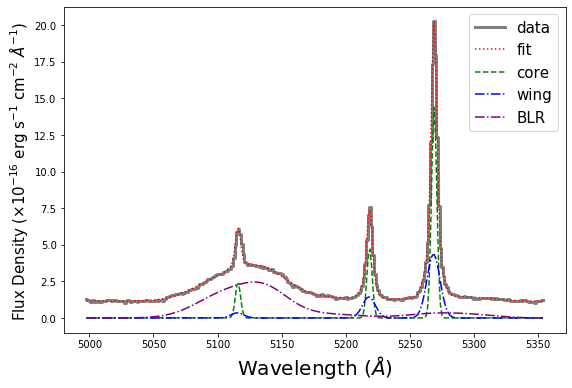

No handles with labels found to put in legend.


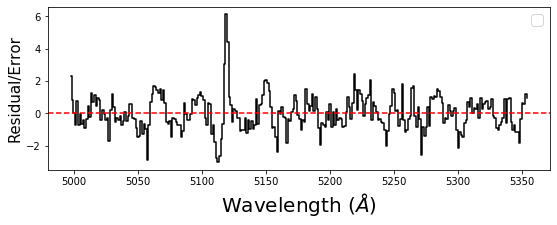

HE0934+0119
8.424928
[8.286275348034659, 49.52413480767321, 15207.052713169665, 72.69404678263808, 4.136380312475732, 22.311147851803046, 15076.666170084378, 168.1908862387358, 21.320032105265597, 3.0418993907663685, 15203.482865696738, 572.0385751905993, 9.113549976703025, 0.5032557390684476, 15199.712871994963, 1485.8815815878186, -3.8520943475770006, 33.886784249123075, 130.38654308528749, 346.8450592339227, 41.79862904759559, 1049.1041750940237, 150.64333247769505, 157.0713027265326, 307.71463520422765, 41.26595858441444, 1097.7782586969581, 1585.3686131507773, 101.33942540320557] [1.29137367e+00 4.34835545e+00 6.43172167e+00 4.51410437e+01
 4.12861954e+00 4.42196475e+00 3.42699654e+01 8.09878384e+01
 6.47379191e+00 7.14241295e-01 3.49475154e+01 2.61550254e+02
 3.79325460e+00 7.28077487e-01 3.88478860e+02 3.30015843e+02
 4.25822750e-01 2.20260614e+00 3.54094884e+01 1.12218632e+01
 7.74485521e-02 1.07545663e+02 3.31505736e+01 3.32998714e+01
 5.50959185e+00 7.70354410e-03 8.50820238e

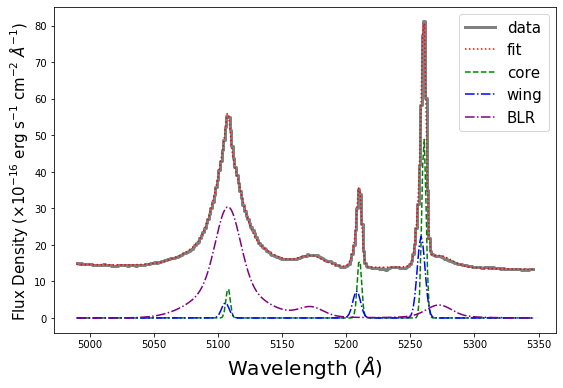

No handles with labels found to put in legend.


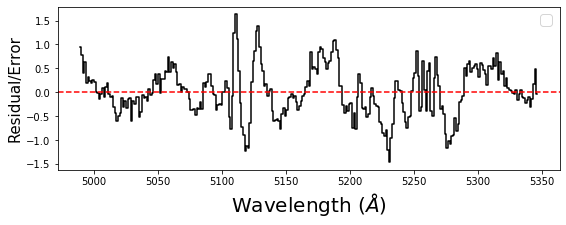

HE1011-0403
8.428375
[5.679536269890197, 32.08203927258825, 17534.893812833518, 100.02832426672782, 2.7635233779305275, 16.628845459368666, 17313.58973819752, 256.71066674713967, 6.569738317513863, 0.3238619907269593, 17809.566589065806, 1831.7711695962391, 22.594407183702643, 3.079744867907822, 17676.803314578883, 823.2411471576897, -0.03264358784569157, 21.095470641466115, 221.3040746359984, 550.3167540393599, 42.00723360995383, 1249.4254886323438, 134.2946502275305, 178.73381313019573, 313.0284633577262, 41.40610707781814, 1250.662831780128, 2102.5110412629856, 127.51098122869593] [9.93576724e-01 1.81708297e+00 5.27818897e+00 8.28003444e+00
 1.07410671e+00 1.59570803e+00 2.35528793e+01 1.30912134e+01
 2.46664190e+00 6.20279021e-01 1.31704860e+02 2.41994596e+02
 1.63916659e+00 4.93142966e-01 3.88543945e+01 5.49081667e+01
 8.81759037e-01 4.56497718e+00 2.13374842e+01 1.81645106e+01
 8.58835939e-03 2.46150948e+01 1.70914731e+01 1.55597411e+01
 6.88926497e+00 9.61523353e-03 7.82770303e+

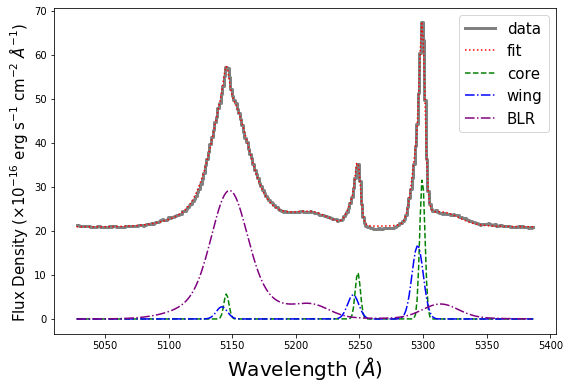

No handles with labels found to put in legend.


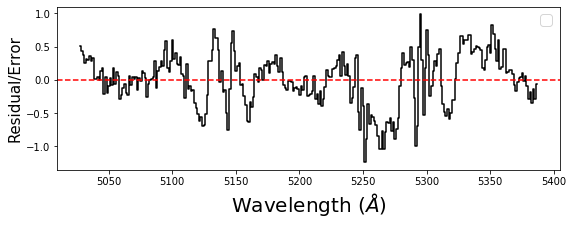

HE1017-0305
3.077139
[2.4187614598666314, 32.110544692238825, 14681.698357314652, 55.214643718073106, 2.132619998738084, 11.966607281802498, 14629.200527940944, 202.77731989654697, 15.883389156293019, 1.7105428946155208, 14471.6843944795, 1951.7432744091957, 0.0, 0.0, 14995.0, 1000.0, -9.497330486387668, 63.80171241446585, 52.497829373707646, 366.3637796186606, 41.87441943361558, 1267.4309828312737, 74.18409594974418, 101.58111835222115, 175.76521430196533, 41.01642804221317, 1874.1185876584207, 4404.9673649942715, 136.49448746514148] [6.51643938e-01 1.12733410e+00 1.87586091e+00 4.27092270e+00
 4.80889594e-01 1.19526497e+00 6.01161427e+00 1.05186425e+01
 9.70792153e-02 8.50688324e-02 1.41174234e+01 1.28483907e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.90912367e-01 1.51407154e+00 6.29909084e+00 1.05655432e+01
 3.49409162e-03 1.01877199e+01 7.71904140e+00 5.57554456e+00
 3.51367893e+00 8.68406627e-03 1.24325091e+01 2.91651605e+01
 6.61398288e+00]


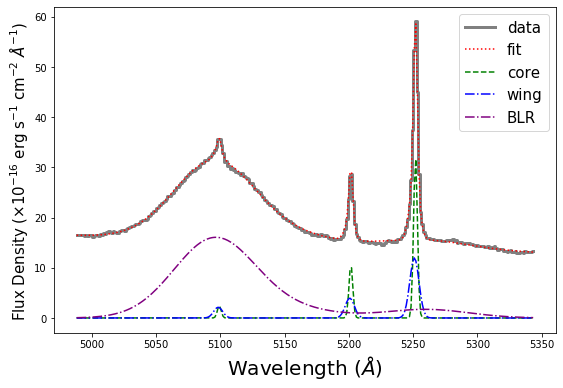

No handles with labels found to put in legend.


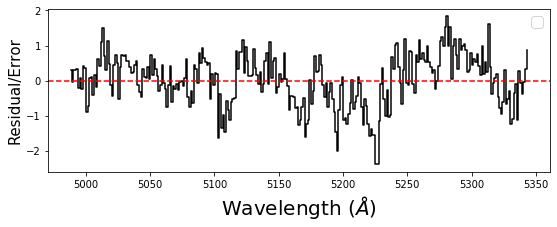

HE1029-1831
4.3160324
[27.454854264955365, 8.28943242407037, 12121.29154495522, 72.18635365345273, 6.585132061025857, 39.883758106423784, 11987.388525424243, 217.16035738993307, 6.062688076176081, 1.9967767740670808, 11965.096263902562, 1623.1303790592724, 8.331780624664846, 0.8584217436586196, 12591.074299308262, 859.3010538695711, -3.682057816257671, 29.468309329260972, 133.90301953097696, 520.6994570327379, 41.41850246249935, 693.5257331866862, 25.03878992263449, 362.59351295452535, 387.6323028771598, 41.16585984364913, 1342.1130612601341, 2528.320439112006, 162.40984448629536] [7.96276664e-01 1.33510393e+00 4.17138480e+00 5.04086114e+00
 1.68885915e+00 9.14928365e-01 4.06594748e+00 3.02970921e+00
 2.20300717e+00 4.90001058e-01 1.65588565e+02 1.82107203e+02
 1.95646736e+00 5.79125985e-01 1.83038547e+02 2.14706590e+02
 4.09475115e-01 2.14093644e+00 5.87903111e+00 6.43363439e+00
 1.85425466e-02 2.90710293e+01 5.22252189e+00 6.56559508e+00
 3.88719925e+00 4.35095577e-03 6.93856093e+01 

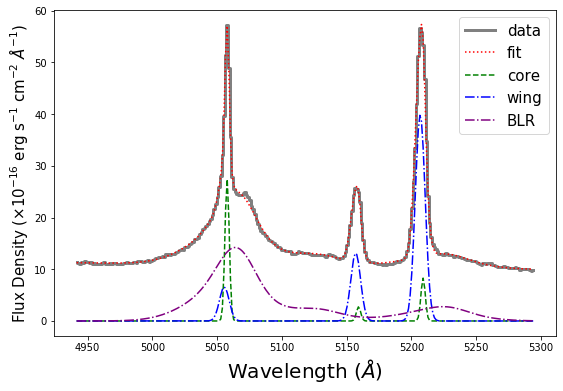

No handles with labels found to put in legend.


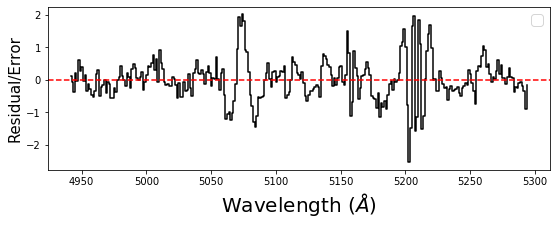

HE1107-0813
12.797466
[2.1570120703139803, 7.928360952575832, 17550.151553451007, 77.77646829566656, 5.2887507835645575, 2.839770464436008, 17425.473602777554, 504.9326502346667, 17.798805990163256, 7.079506087269632, 17568.56740635493, 1055.8095507035, 16.88766045598104, 2.3769844544162413, 16748.496806259787, 1952.9938945100264, -26.665485052951713, 199.15983015118584, 124.67795067345287, 1019.4075565959728, 42.23083510436647, 2114.4415545530132, 25.80317591201169, 60.08653991083442, 85.88971582284611, 40.8395805849105, 1646.140653782835, 3217.0208565024923, 494.475856625903] [2.51256368e+00 1.36550267e+00 2.04729770e+01 4.32113980e+01
 7.28741883e+01 1.01745871e+00 3.94978521e+02 2.39679783e+02
 1.10248139e+02 7.02172429e+01 1.08879587e+02 2.40109767e+02
 7.92061954e+01 7.05720761e+01 5.43513633e+02 2.17242918e+02
 1.32315525e+00 6.96471777e+00 3.97078736e+02 5.55877956e+02
 1.12571289e-01 2.09869543e+03 1.60835372e+01 3.59901608e+01
 3.70434959e+01 1.57476699e-01 1.32609727e+02 4.3

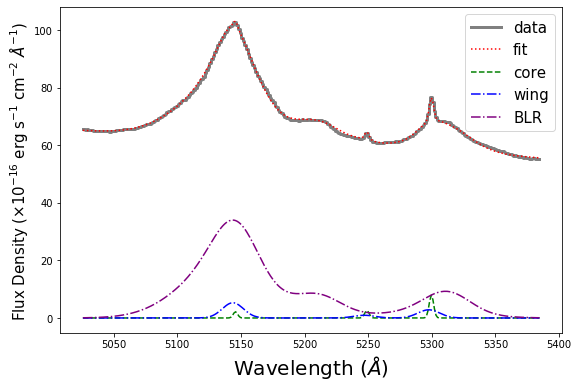

No handles with labels found to put in legend.


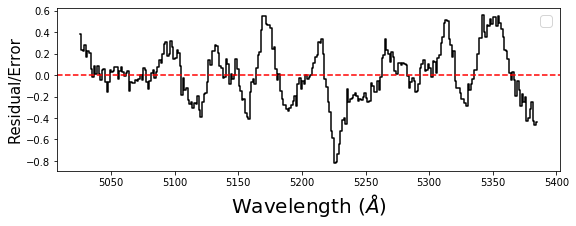

HE1108-2813
7.1498475
[27.105428936673015, 45.111238635467764, 7169.083504878292, 67.85810280069117, 11.637683632285382, 26.897964347789035, 7051.674788291207, 236.92504372363348, 16.460639829696728, 4.641526423718719, 7353.615398270501, 1302.6679773229037, 0.0, 0.0, 7200.0, 1000.0, -6.327929832495052, 52.478522011527886, 117.40871658708511, 492.6830627734706, 41.06002470604085, 874.7705294647518, 128.08953055238078, 266.8101983540785, 394.8997289064593, 40.71461739816878, 1277.0461059891945, 3007.8188479941055, 246.66541332590876] [1.36478764e+00 2.21426757e+00 3.64858091e+00 5.28937875e+00
 1.32762201e+00 1.99673439e+00 8.48297567e+00 1.15430928e+01
 3.81501588e-01 1.85579416e-01 2.16588532e+01 2.64185596e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.16479982e-01 2.60691368e+00 8.61036695e+00 1.61030782e+01
 7.75850507e-03 1.56428541e+01 1.41110298e+01 1.14285222e+01
 8.36949627e+00 9.19898402e-03 2.60167657e+01 6.13019420e+01
 1.06991724e+01]


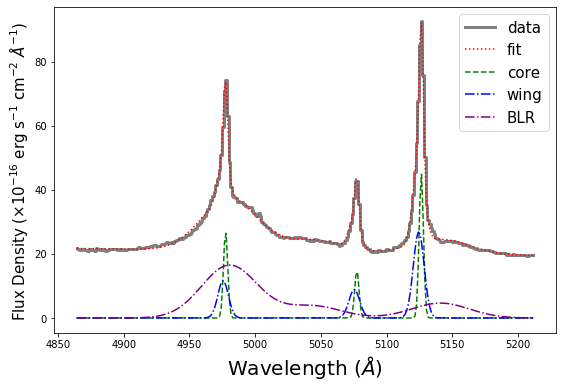

No handles with labels found to put in legend.


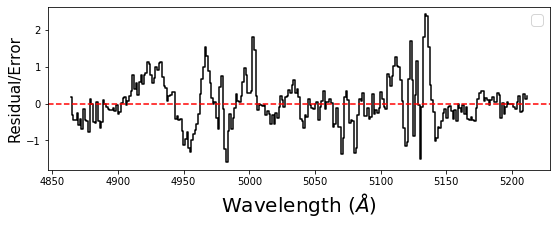

HE1126-0407
4.524307


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10


[9.828324099353681, 116.53027025664282, 18035.809809130315, 114.3501800285328, 18.743383657184875, 22.248395417272988, 17774.383267796384, 344.17316231310855, 74.16599707101457, 9.239049439611566, 18072.64739272434, 720.6113303867819, 54.105378649757824, 12.822949250326031, 17968.0983224431, 1806.8738877705412, -12.299234661851797, 136.10315603709813, 261.4265413339308, 583.4093581179086, 42.755808589392174, 6171.066437857547, 557.6607773180444, 320.7030922862728, 878.3638696043172, 41.90912283064205, 1438.68751373433, 2198.7809920810428, 1217.8901943102808] [2.86361195e+00 2.68147096e+00 3.59531151e+00 6.07004279e+01
 3.75624044e+00 3.64415623e+00 8.07366854e+01 4.89523883e+02
 3.47262234e+00 1.40877659e+00 1.56097067e+01 2.89126592e+01
 3.05490081e+00 1.90696063e+00 4.12149024e+01 5.09711881e+01
 2.40497825e+00 1.23411979e+01 8.19536534e+01 8.80694093e+02
 6.55142191e-03 9.10882075e+01 3.11340284e+01 1.81682731e+02
 1.63645472e+02 1.17408026e-02 3.40525785e+01 5.55465737e+01
 7.81912

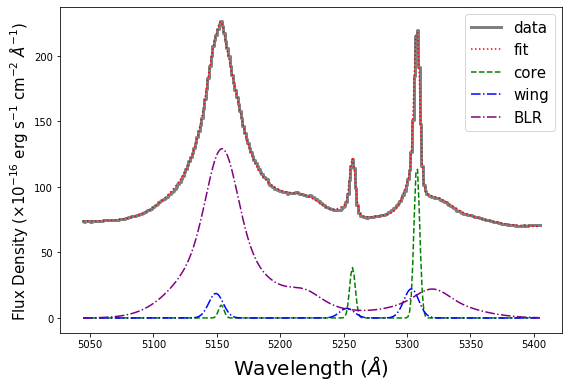

No handles with labels found to put in legend.


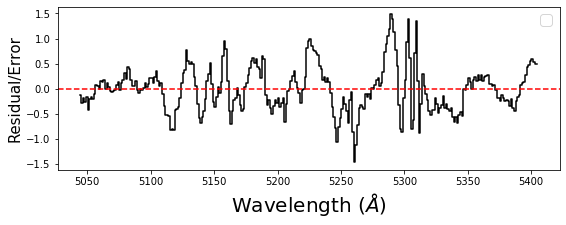

HE1237-0504
32.830757
[19.493849412274056, 224.66297286180614, 2489.6198977512627, 103.76866662192816, 13.476356442725812, 35.680561746898086, 2303.3556424455323, 307.4756635981649, 37.87462856590078, 9.794897545106403, 2453.387873959227, 1679.5697445121566, 0.1, 0.1, 2700.0, 1000.0, -2.658902463771363, 24.09436317171055, 186.26425530573033, 478.6354779606336, 40.670568021088606, 2598.4147075356823, 975.6114917434018, 459.42719461671635, 1435.0386863601182, 40.412723164445, 1674.5018428109477, 3935.959912290968, 671.9856221355479] [2.81557734e+00 5.48705875e+00 2.83045964e+00 4.00018311e+00
 2.32064288e+00 4.44141939e+00 2.11686197e+01 1.84705518e+01
 7.76634637e-01 3.98497756e-01 2.83608407e+01 2.93892007e+01
 2.77555756e-17 2.77555756e-17 0.00000000e+00 0.00000000e+00
 1.06781660e+00 5.30581229e+00 2.07983849e+01 1.42468819e+01
 6.33443178e-03 3.78530290e+01 4.82016555e+01 3.99508127e+01
 2.26991428e+01 6.89020657e-03 2.94213932e+01 6.90744842e+01
 2.89398799e+01]


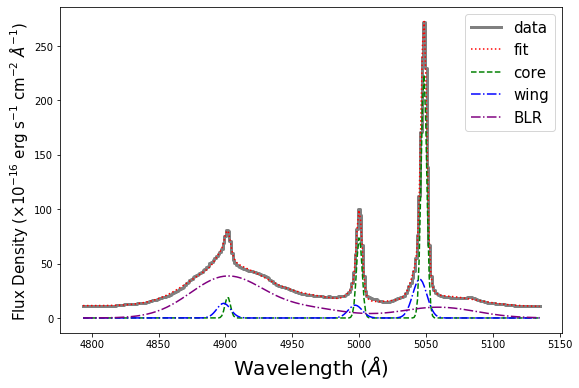

No handles with labels found to put in legend.


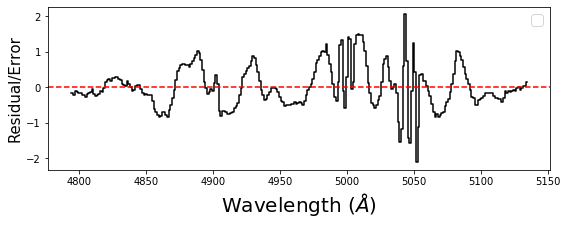

HE1248-1356
2.569574


/home/rickeythecat/Downloads/func.py:191: RuntimeWarning: divide by zero encountered in true_divide
  line = (amplitude)*exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width_recons(vel_sigma, rest_wave))**2))


[12.177153472351026, 73.38919868771981, 4290.981946852806, 57.1898085316128, 1.6081084441996325, 12.682163257775317, 4257.9769961912025, 207.10692442927046, 2.095038259820034, 0.6254754741960488, 4271.4593439915125, 1711.43074721115, 0.0, 0.0, 0.0, 0.0, -0.1312426590883361, 0.9795386346538612, 33.00495066160329, 282.2751507919763, 39.8485469878737, 146.47372116717293, 175.6153647279, 109.95546094120137, 285.57082566910134, 40.138501110130456, 1697.0866264943775, 3993.9687288095492, 43.729855421431395] [1.77584302e+00 1.19874778e+01 1.37424245e+01 2.54197327e+01
 1.61575421e+00 1.00357434e+01 7.91125468e+00 1.96021423e+01
 6.73206090e-02 8.13610132e-02 8.87846195e+01 7.82751315e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.47414698e-01 7.46324785e-01 1.02505677e+01 6.44541592e+00
 1.42641412e-02 4.82764030e+00 2.42808108e+01 2.93456860e+01
 5.98659218e+00 8.41617922e-03 7.82849011e+01 1.83777544e+02
 6.46196444e+00]


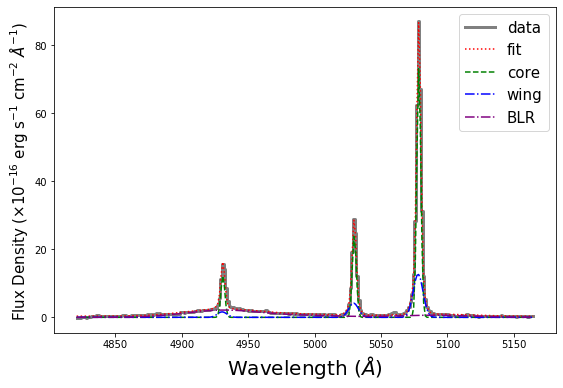

No handles with labels found to put in legend.


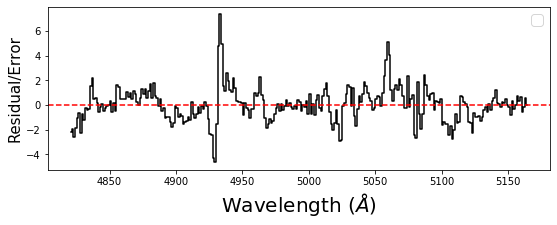

HE1330-1013
4.399627
[3.821892259018144, 16.18964436057188, 6751.4925240388075, 72.72502884892472, 2.176871719499953, 4.019371330441014, 6610.988553372147, 223.72886849406675, 2.897968731407367, 1.2687829432961004, 7006.152535461847, 2060.1450399192963, 6.972239268900591, 0.8650183837687857, 6833.816049802459, 673.1740268605836, -3.7153265867234295, 24.17285431131061, 140.50397066666028, 400.9632821701861, 40.68531410250412, 435.25165606389885, 49.266921633586385, 37.64723467284553, 86.91415630643192, 39.98566418902891, 1582.4571469483171, 1945.7638136490193, 130.61153476343432] [6.37861419e-01 1.05053521e+00 3.36307465e+00 7.75549083e+00
 4.83064375e-01 7.34475121e-01 6.11466394e+01 3.41572371e+01
 1.99798385e-01 1.12689748e-01 6.19641839e+01 8.34252814e+01
 2.77862908e-01 9.78183190e-02 2.02262826e+01 2.56414746e+01
 2.57266334e-01 1.29134664e+00 5.98392365e+01 1.94009704e+01
 8.86014058e-03 8.87022644e+00 8.42925258e+00 8.73342910e+00
 2.12964430e+00 1.06315078e-02 5.54821113e+01 6.

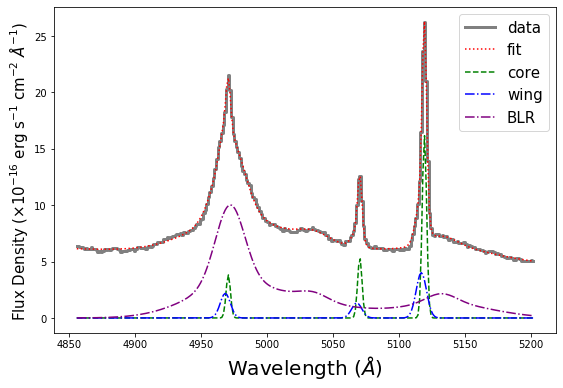

No handles with labels found to put in legend.


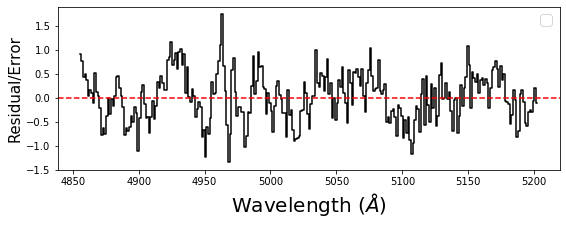

HE1353-1917
1.6287845
[5.236483667906346, 46.4525663467659, 10498.054886538808, 92.87394314992115, 1.085277588164896, 6.600018199640324, 10303.333668336276, 370.2240291842496, 2.7684597985390824, 0.6777144124812021, 8417.494499772078, 1482.601771514932, 2.6842366928288666, 0.185717021324674, 11786.68973597384, 2054.6322106992666, -3.204998771203258, 29.092610487543915, 194.72121820253233, 541.860755807699, 41.04750225127305, 393.1081978533391, 180.53731935917156, 102.34695926272849, 282.8842786219001, 40.904598962691416, 2402.6666874558086, 6476.6226527899025, 56.62146264120908] [1.09535836e-01 1.83321742e-01 3.58501786e-01 7.11932504e-01
 8.19409613e-02 1.28337292e-01 5.49916416e+00 4.74928836e+00
 1.35778079e-01 3.46416021e-02 4.60581028e+01 4.53608335e+01
 6.33990836e-02 4.73132340e-02 1.02297918e+02 6.65271148e+01
 1.57499820e-01 7.95378031e-01 5.48860611e+00 5.97445193e+00
 4.84516973e-03 4.39625672e+00 1.60406072e+00 1.40725889e+00
 1.32614397e+00 2.03941415e-03 1.85919668e+01 5.

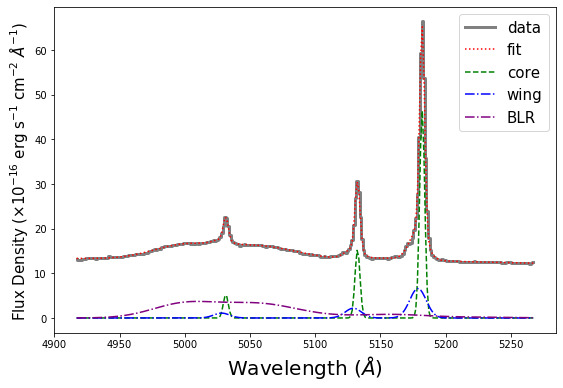

No handles with labels found to put in legend.


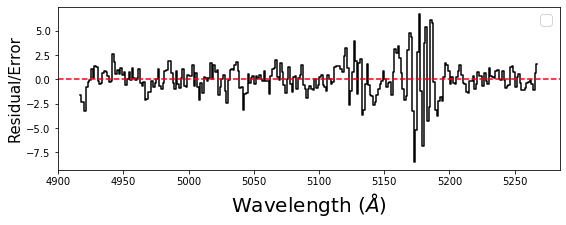

HE1417-0909
3.7506378
[6.899000842880112, 96.4986300464148, 13083.967883390653, 61.39502727866723, 1.5821371751603646, 20.027779164602883, 13049.997954010725, 180.14277313668052, 10.572939915723595, 1.1863278649439104, 13223.087554513095, 1460.0794103399373, 0.0, 0.0, 13200.0, 1000.0, -6.416878783338852, 41.386227952023916, 33.969929379927635, 253.67798644972024, 41.4563571055355, 630.1078138370136, 247.8975045951746, 151.02172368654092, 398.9192282817155, 41.25782721050725, 1405.2798107772178, 3308.97100183512, 70.70071932992543] [6.57048954e-01 2.02904638e+00 8.50371649e-01 2.02427667e+00
 4.61529872e-01 2.12963629e+00 3.61463855e+00 7.40911531e+00
 1.05244851e-01 6.24585016e-02 1.20078271e+01 1.40129975e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.70961138e-01 8.81525615e-01 3.71026481e+00 3.63151650e+00
 3.96022126e-03 5.74370482e+00 1.27308423e+01 1.03211342e+01
 3.47674929e+00 3.79164619e-03 1.35581899e+01 3.19375233e+01
 3.78622036e+00]


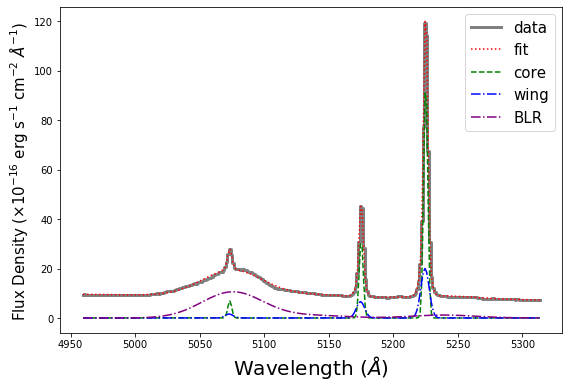

No handles with labels found to put in legend.


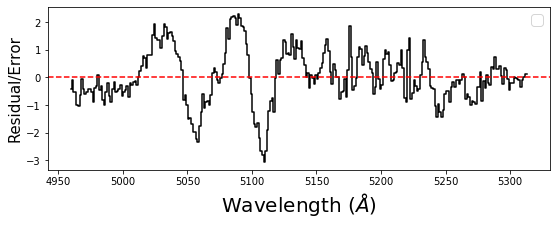

HE2128-0221
2.3917346
[4.296755608005537, 38.42586369173778, 15756.518753445864, 50.31548624489546, 3.966868013989532, 11.556876866281558, 15724.475593449695, -140.6148047663186, 5.259130695661024, 0.641879423938266, 15833.95979169245, 885.7131928851776, 0.0, 0.0, 15744.0, 1000.0, -0.40793300868506094, 6.010999169060736, 32.04315999616847, 224.3072862731329, 41.09355853035652, 189.76449436352652, 80.89600599872601, 67.95117082779134, 148.84717682651734, 40.988084174592245, 843.8002324505994, 1986.4934082258776, 23.16084755727617] [3.45013285e-01 1.06472334e+00 8.99417745e-01 1.85123841e+00
 3.02366715e-01 1.11160114e+00 2.18712552e+00 5.25081678e+00
 6.80707904e-02 2.05141342e-02 5.33492939e+00 1.04253817e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.02623668e-02 3.14125305e-01 2.49217029e+00 2.44404854e+00
 3.19422250e-03 1.39488577e+00 5.10597056e+00 4.23319728e+00
 1.08804266e+00 3.17698443e-03 9.95802157e+00 2.34638771e+01
 7.83230356e-01]


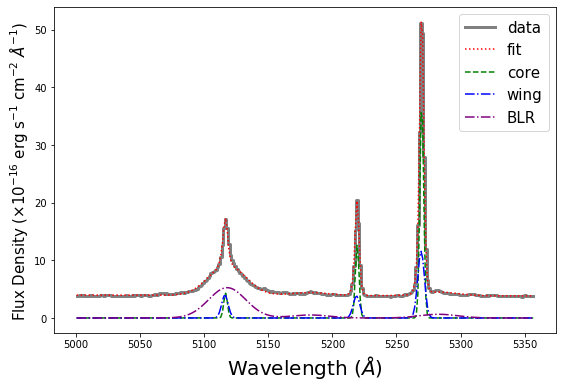

No handles with labels found to put in legend.


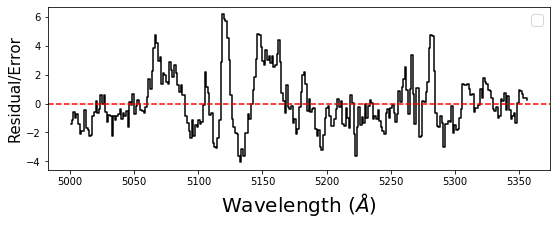

HE2211-3903
1.5005769
[7.89525188177077, 42.47365935298354, 11860.998061787288, 68.43080597242104, 0.46950320833529907, 3.784039995822803, 11761.586312505524, 210.4983839575951, 4.574583206241552, 0.7078375418236923, 11551.67237983987, 2643.135842104927, 0.0, 0.0, 11914.0, 100.0, 0.5302611324289241, 8.187057155145403, 99.41174928176406, 233.97699170727444, 41.260248882065866, 495.49364003664476, 121.61841321518361, 33.34557738306247, 154.96399059824608, 40.75544158935363, 2567.757097918682, 6039.088068623369, 76.6690612762881] [9.46828080e-02 1.57629643e-01 3.10763158e-01 5.42861827e-01
 6.88807760e-02 1.67321305e-01 5.48954794e+00 4.90689727e+00
 1.65507758e-02 2.00651294e-02 9.73937966e+00 1.28639590e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.57382244e-02 4.39927299e-01 5.53741791e+00 1.81276643e+00
 2.63578584e-03 3.00721189e+00 1.27021559e+00 1.03622815e+00
 6.05853935e-01 1.69650307e-03 1.26047697e+01 2.96464103e+01
 2.02392581e+00]


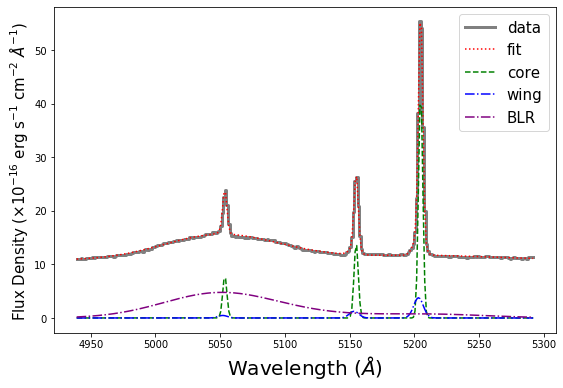

No handles with labels found to put in legend.


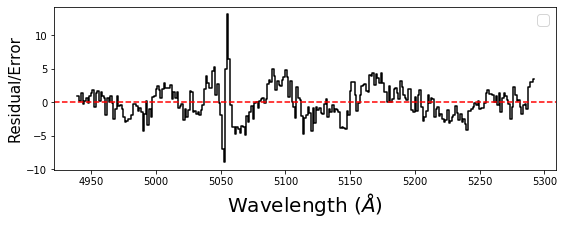

HE2222-0026
4.522535
[2.460604488163857, 7.6346058861927, 17417.9417842112, 120.34790551520346, -0.1813974388768864, 3.0701234214867523, 17251.729081510406, 235.7793043543249, 2.6311306179890894, 0.20930402332746514, 18542.818219118497, 614.8139012578048, 3.7483925626667567, 0.5725183788994777, 17452.68686761876, 1680.0886604457583, -0.10196729482362912, 3.891294254001891, 166.2127027007955, 466.17128015592715, 41.432166094290295, 323.08259281299587, 38.452832716457365, 30.306228932819696, 68.75906164927706, 40.76018247601787, 1505.9590595732466, 3007.8188479941236, 44.52786129936037] [2.53750272e-01 1.38247879e+00 1.75109456e+01 1.88270108e+01
 3.72755476e-01 1.51629719e+00 5.96114408e+01 6.65769274e+01
 2.45112422e-01 7.47686956e-02 2.58402054e+01 4.82233654e+01
 2.08112441e-01 1.02866828e-01 8.98819054e+01 3.69560119e+01
 1.15160989e-01 5.96168422e-01 4.68090226e+01 5.64086041e+01
 6.86782413e-03 5.17524288e+00 1.16911264e+01 9.04178346e+00
 3.77141504e+00 2.32491151e-02 2.75094014e

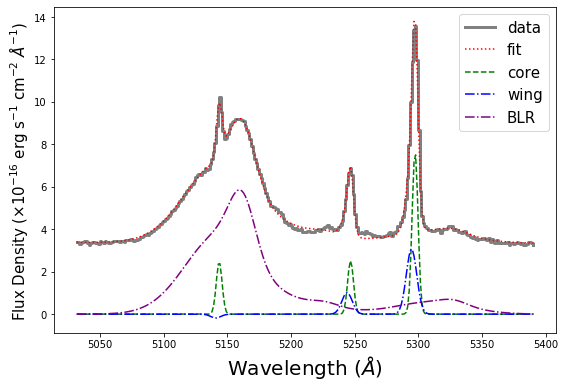

No handles with labels found to put in legend.


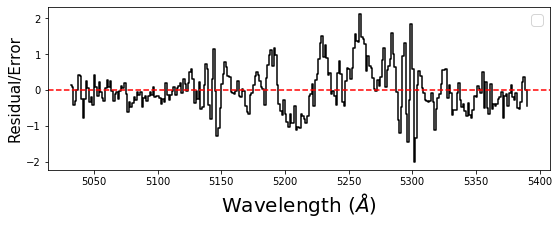

HE2233+0124
1.8545498
[1.0287609681877377, 8.218660148861442, 16983.897764657195, 165.56296733201222, 0.3190956282421186, 1.3519465896205702, 17029.02998480645, 503.4330496750912, 1.1264092233683194, -0.02601119028887848, 15217.721508640027, 1398.790427010198, 1.8829507516835666, 0.23137770037312022, 18237.410886481466, 4351.171667937903, -0.5087417529144066, 4.917525291761948, -45.13222014925486, 630.6722124859969, 41.485874102690566, 401.9854959374875, 56.95513556143883, 28.52066101063012, 85.47579657206896, 40.81350687592361, 3996.2928018636617, 8328.584975898344, 40.01028427216975] [1.35620221e-01 4.73572026e-01 3.28453750e+00 8.84741462e+00
 1.59225965e-01 5.05073675e-01 3.51667261e+01 7.66109790e+01
 1.13565661e-01 5.02660046e-02 1.22774694e+02 1.17467304e+02
 1.14687059e-01 1.32462017e-01 3.51911358e+02 2.53574953e+02
 5.28841636e-01 2.74993384e+00 3.66730529e+01 3.64710566e+01
 3.35279032e-02 3.20966081e+01 5.55907316e+00 4.12722129e+00
 2.46840563e+00 1.26404079e-02 2.26000955

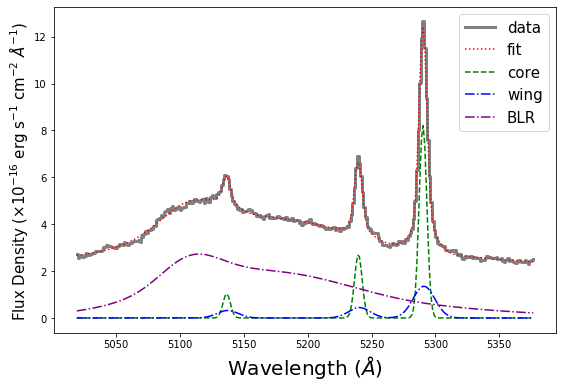

No handles with labels found to put in legend.


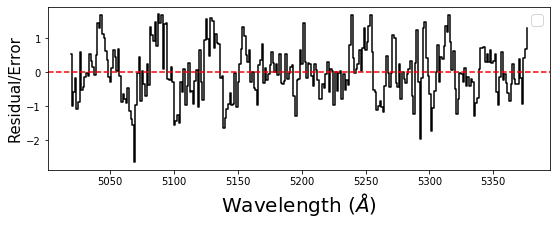

HE2302-0857
4.4628243
[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682, -169.69477343286053, 647.9161898983132, 42.12662535525512, 2589.301809132212, 1927.7445966525981, 937.9735932753516, 2865.71818992795, 42.170676160833146, 2191.0202520981316, 5782.368199775288, 686.3953241773505] [8.25861721e+00 5.31736973e+01 2.79823651e+01 4.02696836e+01
 9.94272014e+00 6.61116536e+01 5.59669047e+01 1.05209542e+02
 4.61866027e+00 1.55255604e+00 3.20610334e+02 3.55337070e+02
 3.22168129e+00 2.00767513e+00 4.22978034e+02 1.39955057e+02
 1.71446810e+00 8.95405732e+00 2.98800676e+01 4.31921290e+01
 2.25414149e-02 1.30264967e+02 6.60778435e+02 5.38227240e+02
 1.25589716e+02 1.96498859e-02 7.88666736e+01

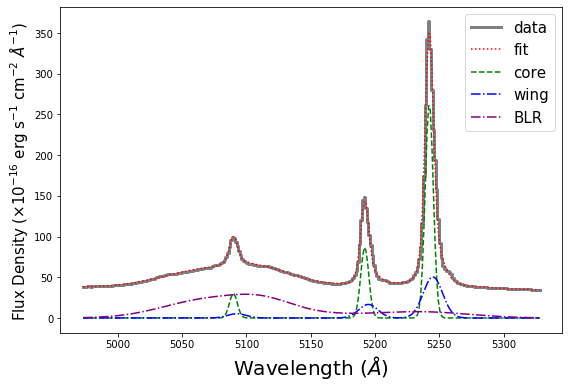

No handles with labels found to put in legend.


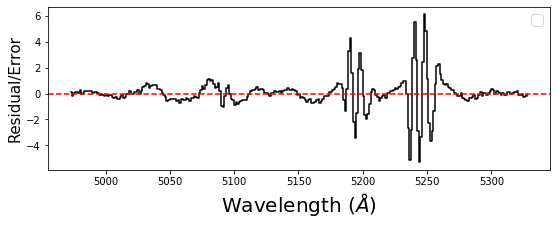

In [7]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}
#'HE0021-1810':False,
p_init= {'HE0021-1810':[1.2078169642715146, 17.216305909165907, 16109.438508035631, 109.45461271403255, 0.3200326636674963, 10.221646289889714, 16011.042931381086, 299.0455462447658, 1.2124073142121425, 1.8963130746612582, 10860.525666229707, 2396.6708995937574, 0.0, 0.0, 15959.0, 1000.0, 1.1610606174311213, 1.7778000884751866]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,-50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[39.237577877692715, 85.34149337269689, 7162.202253621596, 41.6939380680647, 4.144422236073521, 59.5545447193721, 7103.854580346932, 112.41008405668497, 5.925049122295072, 1.8055104262291544, 7035.4076987966255, 1281.3329615128491, 20.665960946360045, 3.710669187171524, 7181.556480474573, 430.8707020614182, 2.3022448079835613, -0.04967981643135043,]
        ,'HE0114-0015':[0.1,1.5,13680,120.0,1.0,3.0,13480,350.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[18.05660859811562, 84.4095920594828, 16343.021367740042, 107.93509209640831, 1.2207224297067296, 65.33996725221164, 16133.361326639886, 241.44542909661888, 10.064952589397885, 0.11922164437143162, 16511.393117676984, 896.3989433325039, 10.634478954988479, 3.3663405963934196, 16351.30789876013, 2390.1171038535563, -12.276316410607894, 79.98110082727592]
        ,'HE0212-0059':[4.785770185809503, 55.77832394058257, 7920.6098244217255, 171.99703901261174, 0.4820655003901233, 5.605123767462352, 7641.049621205695, 439.79913411981, 7.173470331655197, 2.3435094620198083, 6910.053929265311, 3898.3687119322854, 1.901552737188031, 0.8937136428732486, 4628.357538385874, 891.2555075435819, 1.3723940319852157, 0.5501397045686803]
        ,'HE0224-2834':[7.06899403e+00,7.13458601e+01,1.79847558e+04,1.18000676e+02,1.45515224e+00,1.90068487e+01,1.79693125e+04,2.72340813e+02,8.44672986e+00,9.16885096e-01,1.80245745e+04,2.16641488e+03,0,0,0,0,-2.79613744e+00,2.29434665e+01]  
        ,'HE0227-0913':[50.394679609204886, 82.38595301209206, 4793.553851128582, 139.88069655713375, 28.334366378774646, 8.270912161070783, 4343.3627305096015, 308.9287526642564, 43.58112286442538, 6.768950196643075, 4712.578629985357, 1342.2135348231159, 97.23593356125787, 23.388212689292676, 4919.903960937358, 381.7006010971896, -8.85811095519379, 87.8870426811849]
        ,'HE0232-0900':[62.605607017687824, 659.5795559185437, 12876.601985964977, 145.11325604884192, -0.2617074297463765, 162.88547079243193, 12840.898228929938, 326.7436588011667, 97.58591538905621, 14.255215198867113, 12915.831641801858, 2205.2249730825406, 0.0, 0.0, 12942.0, 1000.0, -53.429934070509354, 375.842451064523]                                     
        ,'HE0253-1641':[19.377149011896083, 192.7222508141221, 9545.035688456925, -106.35104204745565, 9.719346198961993, 65.0583386642486, 9296.794498367248, 364.06553165818605, 25.906672696934077, 6.895005665433797, 9726.759430932016, 564.0994046997976, 14.992468948042934, 3.510123911144558, 9170.595823218708, 1730.073739918069, -1.4264470101175397, 47.223653086378945]
        ,'HE0345+0056':[14,180,9300,155,45,123,9100,400,90,18,9300,1500,270,26,9300,400,-7.0,7.16315181e+00]
        ,'HE0351+0240':[18.8530696879267, 287.3703000282673, 10638.538066989542, 70.08455323405626, 7.662275810864878, 17.13831158878082, 10617.184319528338, 238.5930464950352, 10.807426888249795, 0.6027815252673413, 11578.256339143716, 316.04972218771235, 26.062432526710936, 2.6529451225253653, 10656.512134188159, 1304.9068300414383, -3.606660078401498, 31.83983648710957]
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12627,150,0,2.0,12577,300,1.7,0.07,12627,680,1.3,0.2,12627,800,-0.5,4.0]        
        ,'HE0433-1028':[13.498327738787719, 82.0038452771689, 10588.870077859361, 128.10869355257955, 8.4564105787741, 88.98007865504046, 10276.46162253977, 335.3029464396524, 41.237538967081335, 4.233996031305976, 10497.133643970596, 921.6592764548924, 21.289414889397193, 5.680421741006004, 11223.444549651473, 2035.0985618206864, -16.914740179876567, 117.31097424928865]
        ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,100.0,0.1,0.1,15600,1000.0,0.1,0.1,15600,1000.0,-0.001,0.1]
        ,'HE0934+0119':[11,47,15101,60.0,7,24,14901,166.0,28,3.0,15101,1000.0,3,1,15101,2300.0,0.001,0.7]
        ,'HE1011-0403':[6,40,17494,60.0,6,6,17250,200.0,20,4,17494,1000.0,5,3,17494,500.0,0.001,0.7]
        ,'HE1017-0305':[2.55089728e+00,3.32156849e+01,1.46820125e+04,5.64484789e+01,2.28786530e+00,1.19069708e+01,1.46246427e+04,2.07784177e+02,1.56862010e+01,2.28537958e+00,1.45094059e+04,1.94310674e+03,0.00000000e+00,0.00000000e+00,1.49950000e+04,1.00000000e+03,-9.11022180e+00,6.17692724e+01]
        ,'HE1029-1831':[29.92406904,9.69755119,1.21143614e+04,8.07668227e+01,4.81209595,39.5124391,1.19885900e+04,2.28331414e+02,5.96071923,1.62662334,1.20872053e+04,1.73779109e+03,8.66239041,1.11424427,1.25113917e+04,8.45498652e+02,-3.48452009,28.51317335]
        ,'HE1107-0813':[2.73507036,8.85291082,1.75441648e+04,8.62933367e+01,4.33021185,2.62050124,1.73852413e+04,4.85119513e+02,17.72249816,6.91845574,1.75621524e+04,1.00209675e+03,18.13023644,2.78324572,1.68106602e+04,1.91890818e+03,-26.90993593,201.11155123]
        ,'HE1108-2813':[28,35,7200.0,50.0,11,28,7000.0,100.0,16,4.2,7200,1000.0,0,0,7200,1000.0,-8.3,60]
        ,'HE1126-0407':[1.00409949e+00,1.34246331e+01,1.80273208e+04,1.24499810e+02,2.46452048e+00,2.86320853e+00,1.77600119e+04,3.51254916e+02,9.96139933e+00,1.30416561e+00,1.80789175e+04,7.18418498e+02,7.31717375e+00,1.77825637e+00,1.79704287e+04,1.77768741e+03,-9.59655619e-01,1.47131358e+01]
        ,'HE1237-0504':[19.493785248422885, 224.66255315569256, 2489.6203758147267, 103.76802785812963, 13.476391114686468, 35.681396900654065, 2303.3587316914345, 307.4720563892651, 37.87467629974615, 9.794924619485137, 2453.386220593742, 1679.5681005818321, 0.1, 0.1, 2700.0, 1000.0, -2.658895103852454, 24.09433037900086]
        ,'HE1248-1356':[15,70,4395.0,60.0,1.0,3.0,4195.0,-200.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]     
        ,'HE1330-1013':[3.76936095,16.16917122,6.74250778e+03,7.83251391e+01,1.66147304,3.21416158,6.58670246e+03,2.11776429e+02,3.09888431,1.38119428,6.96871099e+03,1.89442503e+03,6.77647519,0.76391275,6.82636521e+03,6.40081695e+02,-3.75920925,24.29039856]
        ,'HE1353-1917':[5.27578675, 48.43043786,1.04881708e+04,8.19955922e+01,1.05886351,6.80260728,1.03058462e+04,4.92698762e+02,2.15521829,0.39784443,8.58992694e+03,1.49126858e+03,3.16250194,0.15731047,1.23263840e+04,1.56483974e+03,-0.001,0.002]
        ,'HE1417-0909':[7,100,13200,50.0,1.6,20,13000,100.0,10,1.2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]      
        ,'HE2128-0221':[4.296778179654671, 38.42538899120943, 15756.519327412814, 50.31479398258997, 3.966839343641518, 11.557385849412487, 15724.475034057066, -140.61219715104798, 5.259163130046745, 0.6418817379477669, 15833.958806117278, 885.7081797795291, 0.0, 0.0, 15744.0, 1000.0, -0.40793445077875623, 6.011008608795197]
        ,'HE2211-3903':[10,42,11914,50.0,2,5,11714,100.0,5,1,11914,1000.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[2.460621313038406, 7.634806779400478, 17417.939139239857, 120.3503410759872, -0.18144337166900082, 3.0698932814920514, 17251.72112349794, 235.78636808210186, 2.6311072711227523, 0.2093100816151153, 18542.81813314071, 614.8103641703985, 3.748413775741454, 0.5725089001892666, 17452.695689891858, 1680.08802962123, -0.1019674970820994, 3.8912963317877263]
        ,'HE2233+0124':[1.2,8.9,1.69833290e+04,1.62971108e+02,0.45,1.5,1.70411796e+04,4.92594446e+02,1.26,0,1.52006283e+04,1.41993597e+03,1.9,0.1,1.83718450e+04,4.09727643e+03,-3.96372168e-01,4.44439203e+00]
        ,'HE2302-0857':[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682]}
#'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   

In [15]:
2.7016231505936656/17.297990394767

0.15618133025504294

HE0114-0015
[9.490022563395085, 9.396294139348184, 13674.430887675928, 124.77376016782897, -0.13126846588927465, 0.6278242406253387, 13667.109953486075, 390.633408635595, 1.7833254675265515, 0.5353495274472366, 13699.16861708158, 1196.4935859997447, 0.0, 0.0, 13680.0, 1000.0, -0.23908225119637544, 2.5907579496122017, 7.320934189852778, 377.0694350028047, 40.6285755054637, 87.01624420706959, 49.06699434742697, 10.273117479586155, 59.340111827013125, 40.46232353152365] [8.88383704e-02 6.46032351e-02 6.46666492e-01 1.13981926e+00
 1.07490138e-01 5.56741230e-02 2.28129414e+01 1.75854601e+01
 4.17736129e-02 1.33230333e-02 9.61245063e+00 1.85474502e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.44679006e-02 1.77139497e-01 2.31182764e+01 4.99643810e+00
 5.81270940e-03 1.16433209e+00 5.94179029e-01 7.26957215e-01
 4.14425257e-01 3.02850196e-03]


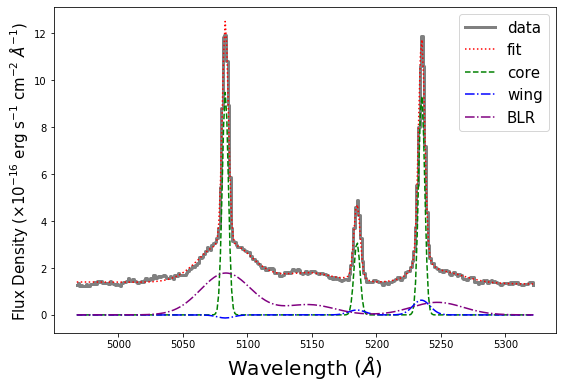

No handles with labels found to put in legend.


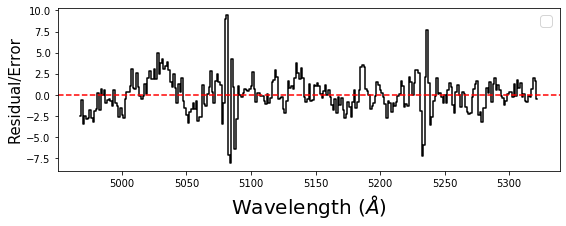

In [8]:
z = {"HE0114-0015":0.04560}

objs = z.keys()

broad2= {'HE0114-0015':False}
#'HE0021-1810':False,
p_init= {'HE0114-0015':[9.49004680758341, 9.396339789022234, 13674.43099983812, 124.77444289234994, -0.13132264613174283, 0.6277728114102422, 13667.099698829676, 390.65109512546394, 1.7833455112870613, 0.5353495302825251, 13699.168335667626, 1196.487856196145, 0.0, 0.0, 13680.0, 1000.0, -0.23908159151410913, 2.5907549102410443]}
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   

HE1107-0813
12.797466


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10


[2.1570120703139803, 7.928360952575832, 17550.151553451007, 77.77646829566656, 5.2887507835645575, 2.839770464436008, 17425.473602777554, 504.9326502346667, 17.798805990163256, 7.079506087269632, 17568.56740635493, 1055.8095507035, 16.88766045598104, 2.3769844544162413, 16748.496806259787, 1952.9938945100264, -26.665485052951713, 199.15983015118584, 124.67795067345287, 1019.4075565959728, 42.23083510436647, 2114.4415545530132, 25.80317591201169, 60.08653991083442, 85.88971582284611, 40.8395805849105, 1646.140653782835, 3217.0208565024923, 494.475856625903] [2.34180724e+00 1.30867320e+00 1.63880981e+01 4.16580136e+01
 5.40567214e+03 1.35291447e+00 2.08348688e+02 3.78325150e+02
 5.40558254e+03 7.49835513e+01 1.16117814e+02 2.60361532e+02
 4.64949930e+01 7.52596716e+01 6.06352471e+02 2.20594954e+02
 1.75663556e+00 9.27451876e+00 2.11047773e+02 8.38882372e+02
 1.00261558e-01 2.11887640e+02 1.64943791e+01 7.05406553e+01
 6.89906920e+01 1.44651885e-01 1.56692481e+02 5.04702051e+02
 7.9433014

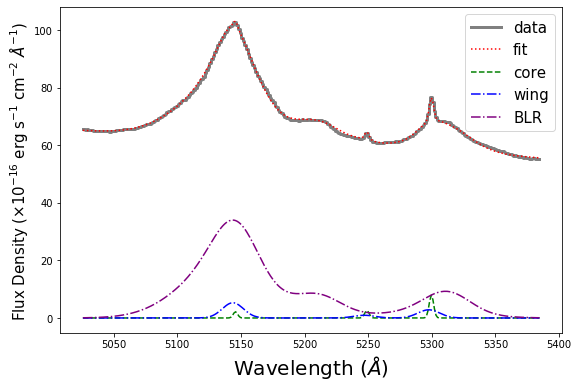

No handles with labels found to put in legend.


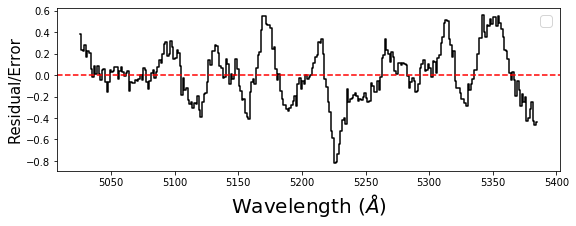

In [25]:
z = {'HE1107-0813':0.058}
objs = z.keys()

broad2 = {'HE1107-0813':True}
p_init = {'HE1107-0813':[2.73507036,8.85291082,1.75441648e+04,8.62933367e+01,4.33021185,2.62050124,1.73852413e+04,4.85119513e+02,17.72249816,6.91845574,1.75621524e+04,1.00209675e+03,18.13023644,2.78324572,1.68106602e+04,1.91890818e+03,-26.90993593,201.11155123]}

for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   